<h1 style="font-size:32px; text-align:center;">Projet Scoring</h1>
<hr>
<h1 style="font-size:18px; text-align:center; margin-bottom:24px;">Ousmane KA</h1>
<hr>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno as msno
from skimpy import skim
import warnings
import os
import itertools
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from scipy.stats import skew
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency, mannwhitneyu
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./Dataset/hmeq.csv')

<span style="color:#0A8791; font-size:24px;"><b><u>Analyse Exploratoire des données</u></b></span>

In [4]:
num_cols = df.select_dtypes(include=['float64', 'int64']) 
cat_cols = df.select_dtypes(include=['object']) 

print("Variables numériques:")
print(num_cols.columns.tolist())

print("Variables catégoriques:")
print(cat_cols.columns.tolist())

Variables numériques:
['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
Variables catégoriques:
['REASON', 'JOB']


In [5]:
for col in cat_cols:
    print('{} ({}) : {}'.format(col, len(df[col].unique()), df[col].unique()))

REASON (3) : ['HomeImp' nan 'DebtCon']
JOB (7) : ['Other' nan 'Office' 'Sales' 'Mgr' 'ProfExe' 'Self']


In [6]:
df.head()

BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1    1  1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2    1  1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3    1  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4    0  1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   

        CLAGE  NINQ  CLNO  DEBTINC  
0   94.366667   1.0   9.0      NaN  
1  121.833333   0.0  14.0      NaN  
2  149.466667   1.0  10.0      NaN  
3         NaN   NaN   NaN      NaN  
4   93.333333   0.0  14.0      NaN

- BAD : Variable cible (0 = bon crédit, 1 = mauvais crédit).
- LOAN : Montant du prêt demandé.
- MORTDUE : Montant dû sur l’hypothèque actuelle (contient des valeurs manquantes).
- VALUE : Valeur estimée de la propriété.
- REASON : Raison du prêt (Catégorique : "DebtCon" pour consolidation de dettes, "HomeImp" pour amélioration de l’habitat).
- JOB : Type d’emploi (Catégorique, ex: "Other", "Office", etc.).
- YOJ : Années d’expérience dans le travail actuel.
- DEROG : Nombre de rapports négatifs dans l'historique de crédit.
- DELINQ : Nombre de délais de paiement dans l’historique de crédit.
- CLAGE : Âge moyen des comptes de crédit en mois.
- NINQ : Nombre de demandes de crédit récentes.
- CLNO : Nombre total de lignes de crédit.
- DEBTINC : Ratio dette/revenu (contient des valeurs manquantes).

Prenons un exemple de notre ensemble de données pour comprendre le système d'équité domiciliaire.

LOAN : 1,100
Le montant du prêt demandé par cette personne est de 1,100.

MORTDUE : 25,860.0
Le montant dû sur l'hypothèque existante de cette personne est de 25,860.

VALUE : 39,025.0
La valeur actuelle de la propriété de cette personne est de 39,025.0.

REASON : HomeImp
Cette personne est en train de consolider ses dettes.

JOB : Other
Le type d'emploi de cette personne est "Autre".

YOJ : 10.5
Cette personne travaille depuis 10.5 ans.

DEROG : 0.0
Le nombre de rapports dérogatoires majeurs de cette personne est de 0.0.

DELINQ : 0.0
Le nombre de lignes de crédit délinquantes de cette personne est de 0.0.

CLAGE : 94.366667
L'âge de la plus ancienne ligne de crédit de cette personne est de 94.37 mois.

NINQ : 1.0
Le nombre de demandes de crédit récentes de cette personne est de 1.0.

CLNO : 9.0
Le nombre de lignes de crédit de cette personne est de 9.0.

DEBTINC : NaN (non donné)
Le ratio dette-revenu de cette personne n'est pas fourni.

En résumé, sur la base des informations ci-dessus, cette personne a un historique d'emploi relativement stable, un comportement de crédit positif et un intérêt à consolider ses dettes existantes. La valeur de sa propriété actuelle et le montant dû sur son hypothèque suggèrent une source potentielle de garantie pour le montant du prêt demandé. Cependant, l'absence du ratio dette-revenu qui a fait défaut sur son paiement par carte de crédit le mois suivant.

In [7]:
rows, columns = df.shape
print(f"Le DataFrame contient {rows} lignes et {columns} colonnes.")

Le DataFrame contient 5960 lignes et 13 colonnes.


In [8]:
# Help functions
def missing_values_table(df: pd.DataFrame) -> pd.DataFrame:
    """Compte les valeurs manquantes dans un dataframe et retourne un tableau avec les résultats

    Args:
        df (pd.DataFrame): un dataframe

    Returns:
        pd.DataFrame: Un dataframe avec les valeurs manquantes et le pourcentage de valeurs manquantes pour chaque colonne
    """
    # Total des valeurs manquantes
    mis_val = df.isnull().sum()
    
    # Pourcentage de valeurs manquantes
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Créer un tableau avec les résultats
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Renommer les colonnes
    tableau_valeurs_manquantes_renomme  = mis_val_table.rename(
    columns = {0 : 'Valeurs manquantes', 1 : '% du total'})
    
    # Trier le tableau par pourcentage de valeurs manquantes décroissant
    tableau_valeurs_manquantes_renomme  = tableau_valeurs_manquantes_renomme [
        tableau_valeurs_manquantes_renomme .iloc[:,1] != 0].sort_values(
    '% du total', ascending=False).round(1)
    
    # Retourner le dataframe avec les informations sur les valeurs manquantes
    return tableau_valeurs_manquantes_renomme 

# Statistiques des valeurs manquantes
missing_values = missing_values_table(df)

# Afficher des informations sommaires
print (f"Le dataset a {str(df.shape[1])} colonnes dont {str(missing_values.shape[0])} ont des valeurs manquantes.")      
missing_values

Le dataset a 13 colonnes dont 11 ont des valeurs manquantes.


Valeurs manquantes  % du total
DEBTINC                1267        21.3
DEROG                   708        11.9
DELINQ                  580         9.7
MORTDUE                 518         8.7
YOJ                     515         8.6
NINQ                    510         8.6
CLAGE                   308         5.2
JOB                     279         4.7
REASON                  252         4.2
CLNO                    222         3.7
VALUE                   112         1.9

In [9]:
#Un résumé concis du dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Cette sortie de table fournit, d’une part, des informations sur les types de chaque variable et, d’autre part, permet de détecter la présence de valeurs manquantes dans les colonnes. 

In [10]:
df.describe()

BAD          LOAN        MORTDUE          VALUE          YOJ  \
count  5960.000000   5960.000000    5442.000000    5848.000000  5445.000000   
mean      0.199497  18607.969799   73760.817200  101776.048741     8.922268   
std       0.399656  11207.480417   44457.609458   57385.775334     7.573982   
min       0.000000   1100.000000    2063.000000    8000.000000     0.000000   
25%       0.000000  11100.000000   46276.000000   66075.500000     3.000000   
50%       0.000000  16300.000000   65019.000000   89235.500000     7.000000   
75%       0.000000  23300.000000   91488.000000  119824.250000    13.000000   
max       1.000000  89900.000000  399550.000000  855909.000000    41.000000   

             DEROG       DELINQ        CLAGE         NINQ         CLNO  \
count  5252.000000  5380.000000  5652.000000  5450.000000  5738.000000   
mean      0.254570     0.449442   179.766275     1.186055    21.296096   
std       0.846047     1.127266    85.810092     1.728675    10.138933   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000   115.116702     0.000000    15.000000   
50%       0.000000     0.000000   173.466667     1.000000    20.000000   
75%       0.000000     0.000000   231.562278     2.000000    26.000000   
max      10.000000    15.000000  1168.233561    17.000000    71.000000   

           DEBTINC  
count  4693.000000  
mean     33.779915  
std       8.601746  
min       0.524499  
25%      29.140031  
50%      34.818262  
75%      39.003141  
max     203.312149

In [11]:
# Statistiques descriptives
df.describe(include='all').T

count unique      top  freq           mean           std       min  \
BAD      5960.0    NaN      NaN   NaN       0.199497      0.399656       0.0   
LOAN     5960.0    NaN      NaN   NaN   18607.969799  11207.480417    1100.0   
MORTDUE  5442.0    NaN      NaN   NaN     73760.8172  44457.609458    2063.0   
VALUE    5848.0    NaN      NaN   NaN  101776.048741  57385.775334    8000.0   
REASON     5708      2  DebtCon  3928            NaN           NaN       NaN   
JOB        5681      6    Other  2388            NaN           NaN       NaN   
YOJ      5445.0    NaN      NaN   NaN       8.922268      7.573982       0.0   
DEROG    5252.0    NaN      NaN   NaN        0.25457      0.846047       0.0   
DELINQ   5380.0    NaN      NaN   NaN       0.449442      1.127266       0.0   
CLAGE    5652.0    NaN      NaN   NaN     179.766275     85.810092       0.0   
NINQ     5450.0    NaN      NaN   NaN       1.186055      1.728675       0.0   
CLNO     5738.0    NaN      NaN   NaN      21.296096     10.138933       0.0   
DEBTINC  4693.0    NaN      NaN   NaN      33.779915      8.601746  0.524499   

                25%         50%         75%          max  
BAD             0.0         0.0         0.0          1.0  
LOAN        11100.0     16300.0     23300.0      89900.0  
MORTDUE     46276.0     65019.0     91488.0     399550.0  
VALUE       66075.5     89235.5   119824.25     855909.0  
REASON          NaN         NaN         NaN          NaN  
JOB             NaN         NaN         NaN          NaN  
YOJ             3.0         7.0        13.0         41.0  
DEROG           0.0         0.0         0.0         10.0  
DELINQ          0.0         0.0         0.0         15.0  
CLAGE    115.116702  173.466667  231.562278  1168.233561  
NINQ            0.0         1.0         2.0         17.0  
CLNO           15.0        20.0        26.0         71.0  
DEBTINC   29.140031   34.818262   39.003141   203.312149

In [12]:
df.describe().transpose()

count           mean           std          min           25%  \
BAD      5960.0       0.199497      0.399656     0.000000      0.000000   
LOAN     5960.0   18607.969799  11207.480417  1100.000000  11100.000000   
MORTDUE  5442.0   73760.817200  44457.609458  2063.000000  46276.000000   
VALUE    5848.0  101776.048741  57385.775334  8000.000000  66075.500000   
YOJ      5445.0       8.922268      7.573982     0.000000      3.000000   
DEROG    5252.0       0.254570      0.846047     0.000000      0.000000   
DELINQ   5380.0       0.449442      1.127266     0.000000      0.000000   
CLAGE    5652.0     179.766275     85.810092     0.000000    115.116702   
NINQ     5450.0       1.186055      1.728675     0.000000      0.000000   
CLNO     5738.0      21.296096     10.138933     0.000000     15.000000   
DEBTINC  4693.0      33.779915      8.601746     0.524499     29.140031   

                  50%            75%            max  
BAD          0.000000       0.000000       1.000000  
LOAN     16300.000000   23300.000000   89900.000000  
MORTDUE  65019.000000   91488.000000  399550.000000  
VALUE    89235.500000  119824.250000  855909.000000  
YOJ          7.000000      13.000000      41.000000  
DEROG        0.000000       0.000000      10.000000  
DELINQ       0.000000       0.000000      15.000000  
CLAGE      173.466667     231.562278    1168.233561  
NINQ         1.000000       2.000000      17.000000  
CLNO        20.000000      26.000000      71.000000  
DEBTINC     34.818262      39.003141     203.312149

In [13]:
#Des statistiques plus lisibles des variables
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5960   │ │ float64     │ 9     │                                                          │
│ │ Number of columns │ 13     │ │ int32       │ 2     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column   ┃ NA   ┃ NA %               ┃ mean   ┃ sd     ┃ p0     ┃ p25   ┃ p50   ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ BAD      │    0 │                  0 │ 0.1995 │ 0.3997 │      0 │     0 │     0 │      0 │      1 │ ▇    ▂ │  │
│ │ LOAN     │    0 │                  0 │  18610 │  11210 │   1100 │ 11100 │ 16300 │  23300 │  89900 │  ▇▇▁   │  │
│ │ MORTDUE  │  518 │  8.691275167785236 │  73760 │  44460 │   2063 │ 46280 │ 65020 │  91490 │ 399600 │  ▇▆▁   │  │
│ │ VALUE    │  112 │ 1.8791946308724832 │ 101800 │  57390 │   8000 │ 66080 │ 89240 │ 119800 │ 855900 │   ▇▁   │  │
│ │ YOJ      │  515 │  8.640939597315436 │  8.922 │  7.574 │      0 │     3 │     7 │     13 │     41 │  ▇▅▂▁  │  │
│ │ DEROG    │  708 │ 11.879194630872483 │ 0.2546 │  0.846 │      0 │     0 │     0 │      0 │     10 │   ▇    │  │
│ │ DELINQ   │  580 │  9.731543624161073 │ 0.4494 │  1.127 │      0 │     0 │     0 │      0 │     15 │   ▇    │  │
│ │ CLAGE    │  308 │  5.167785234899329 │  179.8 │  85.81 │      0 │ 115.1 │ 173.5 │  231.6 │   1168 │   ▇▅   │  │
│ │ NINQ     │  510 │  8.557046979865772 │  1.186 │  1.729 │      0 │     0 │     1 │      2 │     17 │   ▇▁   │  │
│ │ CLNO     │  222 │ 3.7248322147651005 │   21.3 │  10.14 │      0 │    15 │    20 │     26 │     71 │  ▂▇▅▁  │  │
│ │ DEBTINC  │ 1267 │ 21.258389261744966 │  33.78 │  8.602 │ 0.5245 │ 29.14 │ 34.82 │     39 │  203.3 │   ▇▇   │  │
│ └──────────┴──────┴────────────────────┴────────┴────────┴────────┴───────┴───────┴────────┴────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━┳━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃        ┃     ┃            ┃          ┃         ┃         ┃         ┃ chars per  ┃ words per   ┃ total      ┃  │
│ ┃ column ┃ NA  ┃ NA %       ┃ shortest ┃ longest ┃ min     ┃ max     ┃ row        ┃ row         ┃ words      ┃  │
│ ┡━━━━━━━━╇━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩  │
│ │ REASON │ 252 │ 4.22818791 │ HomeImp  │ HomeImp │ DebtCon │ HomeImp │          7 │        0.96 │       5708 │  │
│ │        │     │    9463087 │          │         │         │         │            │             │            │  │
│ │ JOB    │ 279 │ 4.68120805 │ Mgr      │ ProfExe │ Mgr     │ Self    │       5.31 │        0.95 │       5681 │  │
│ │        │     │    3691275 │          │         │         │         │            │             │            │  │
│ └────────┴─────┴────────────┴──────────┴─────────┴────

<Axes: xlabel='CLNO', ylabel='Density'>

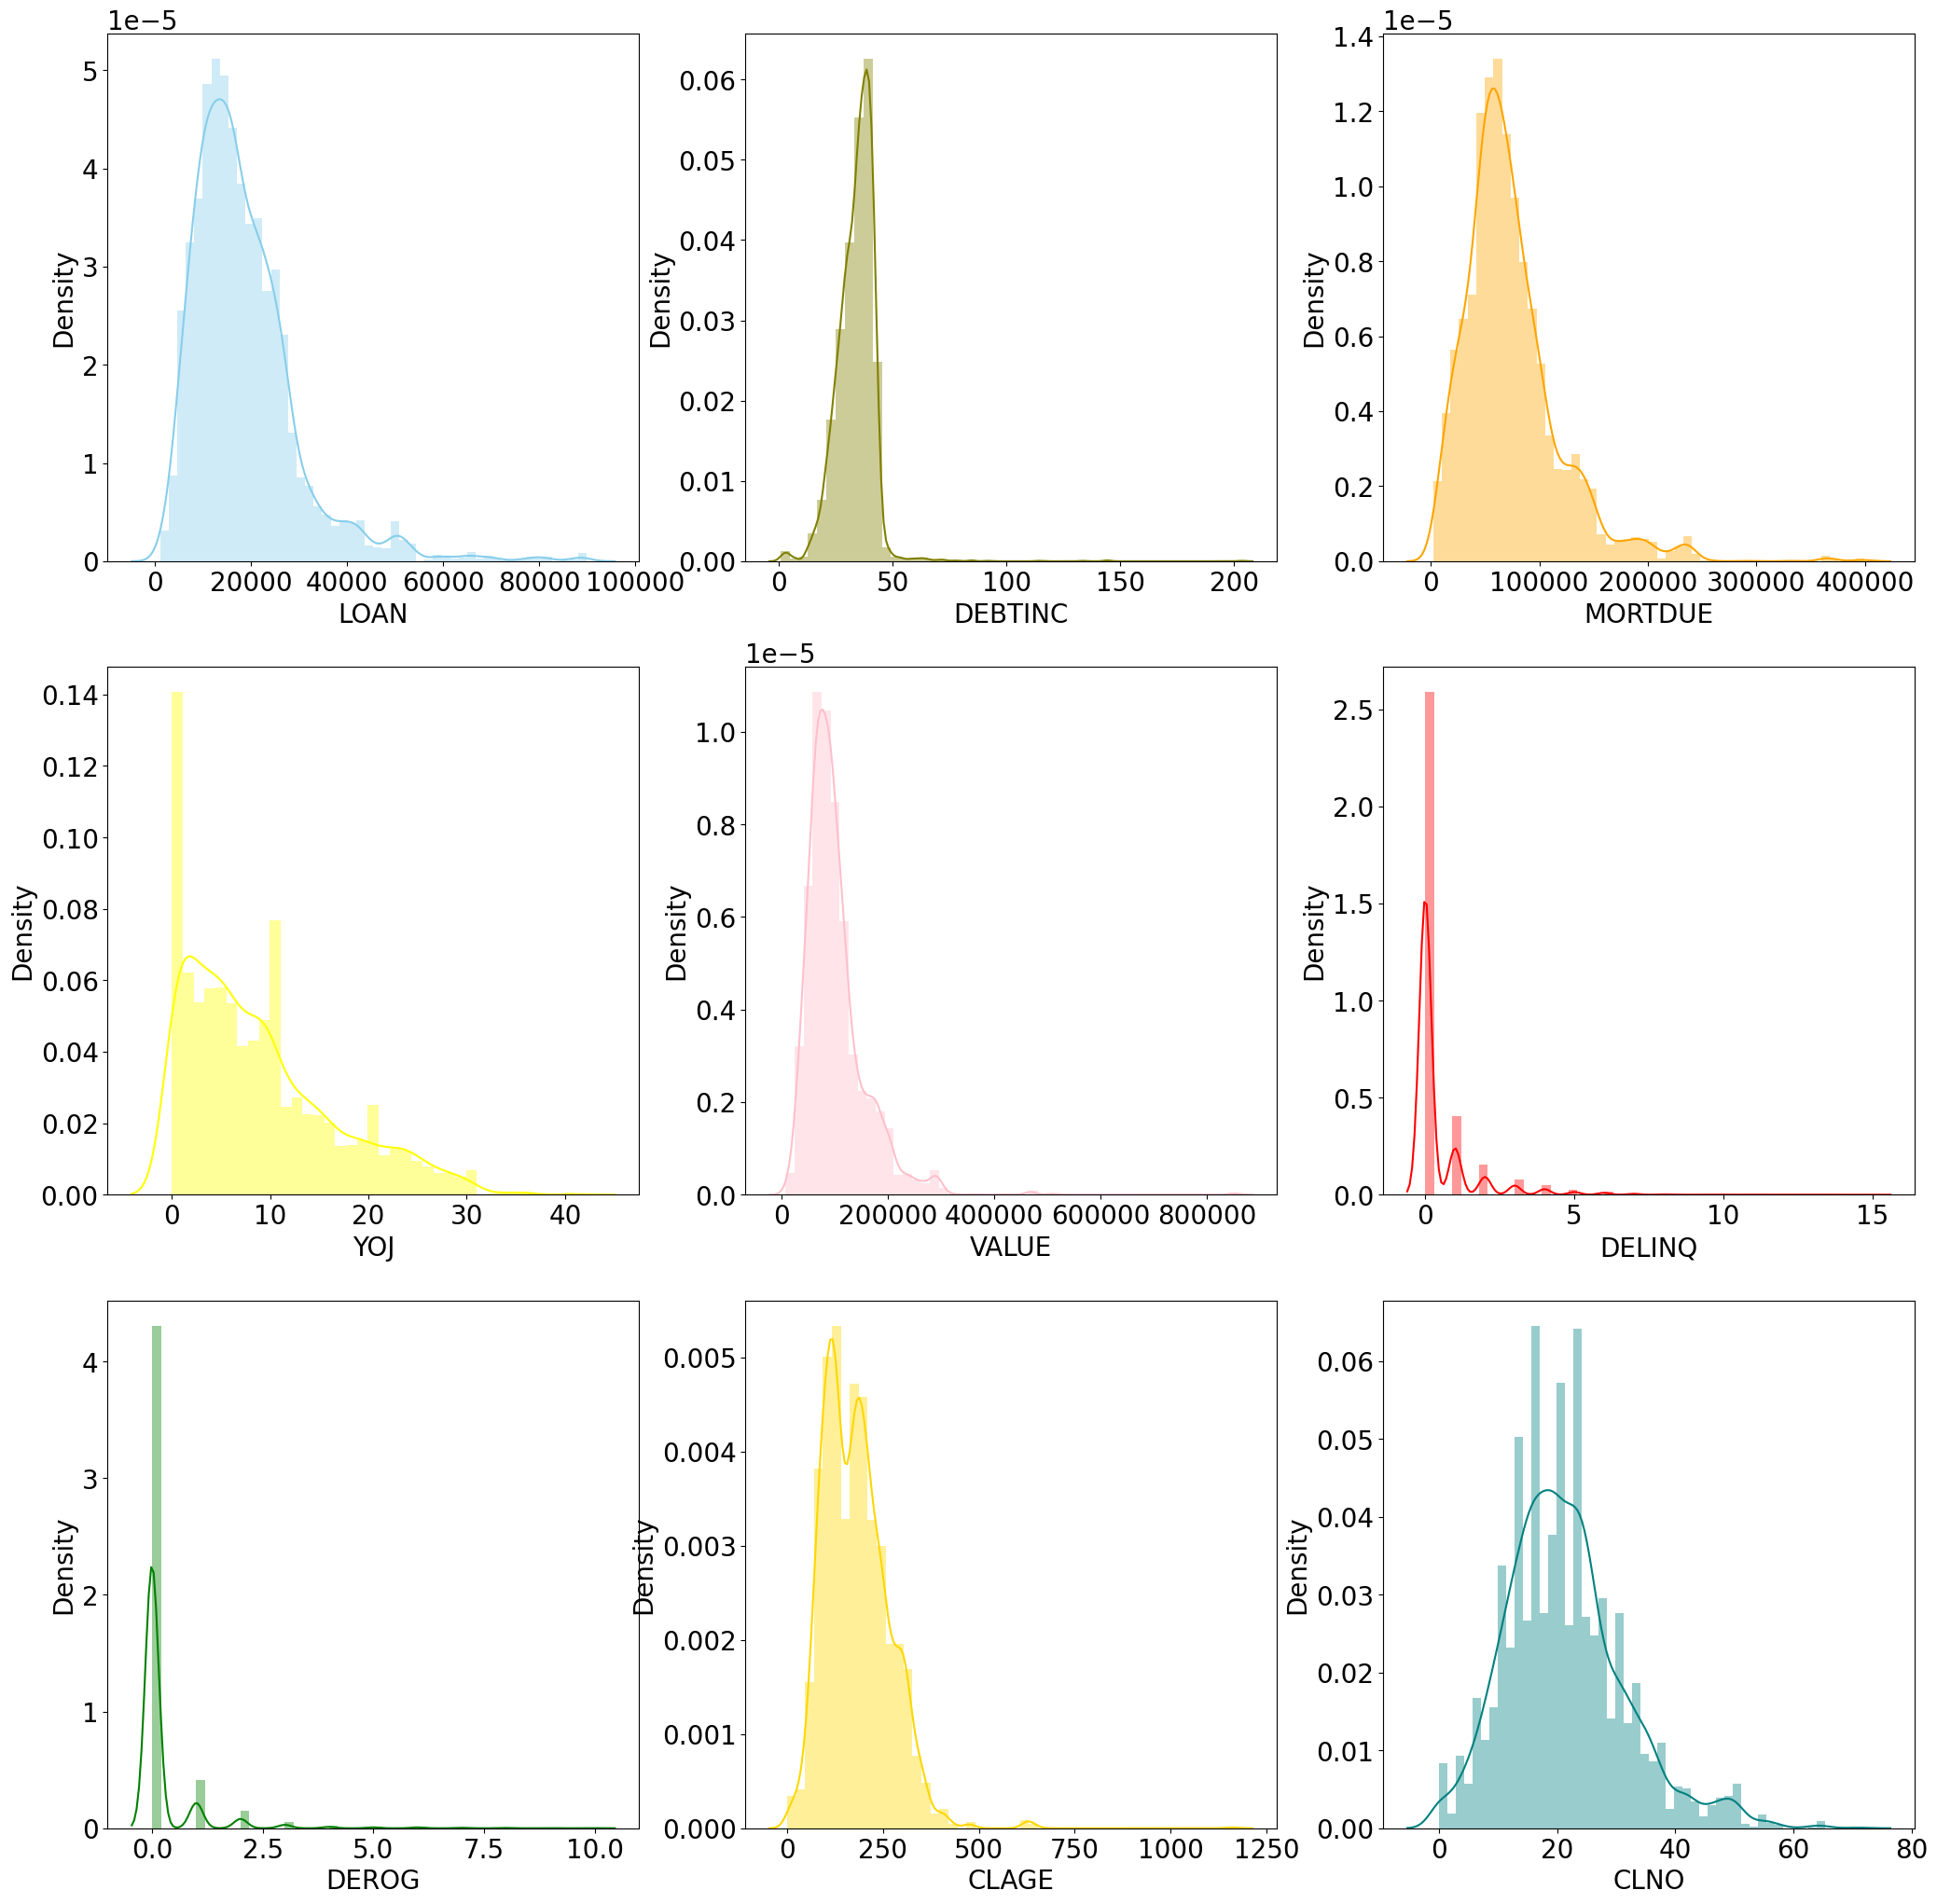

In [14]:
import matplotlib as mpl
mpl.rcParams['font.size'] =20
f, axes = plt.subplots(3, 3, figsize=(25,25))
sns.distplot( df["LOAN"] , color="skyblue", ax=axes[0, 0])
sns.distplot( df["DEBTINC"] , color="olive", ax=axes[0, 1])
sns.distplot( df["MORTDUE"] , color="orange", ax=axes[0, 2])
sns.distplot( df["YOJ"] , color="yellow", ax=axes[1, 0])
sns.distplot( df["VALUE"] , color="pink", ax=axes[1, 1])
sns.distplot( df["DELINQ"] , color="red", ax=axes[1, 2])
sns.distplot( df["DEROG"] , color="green", ax=axes[2, 0])
sns.distplot( df["CLAGE"] , color="gold", ax=axes[2, 1])
sns.distplot( df["CLNO"] , color="teal", ax=axes[2, 2])

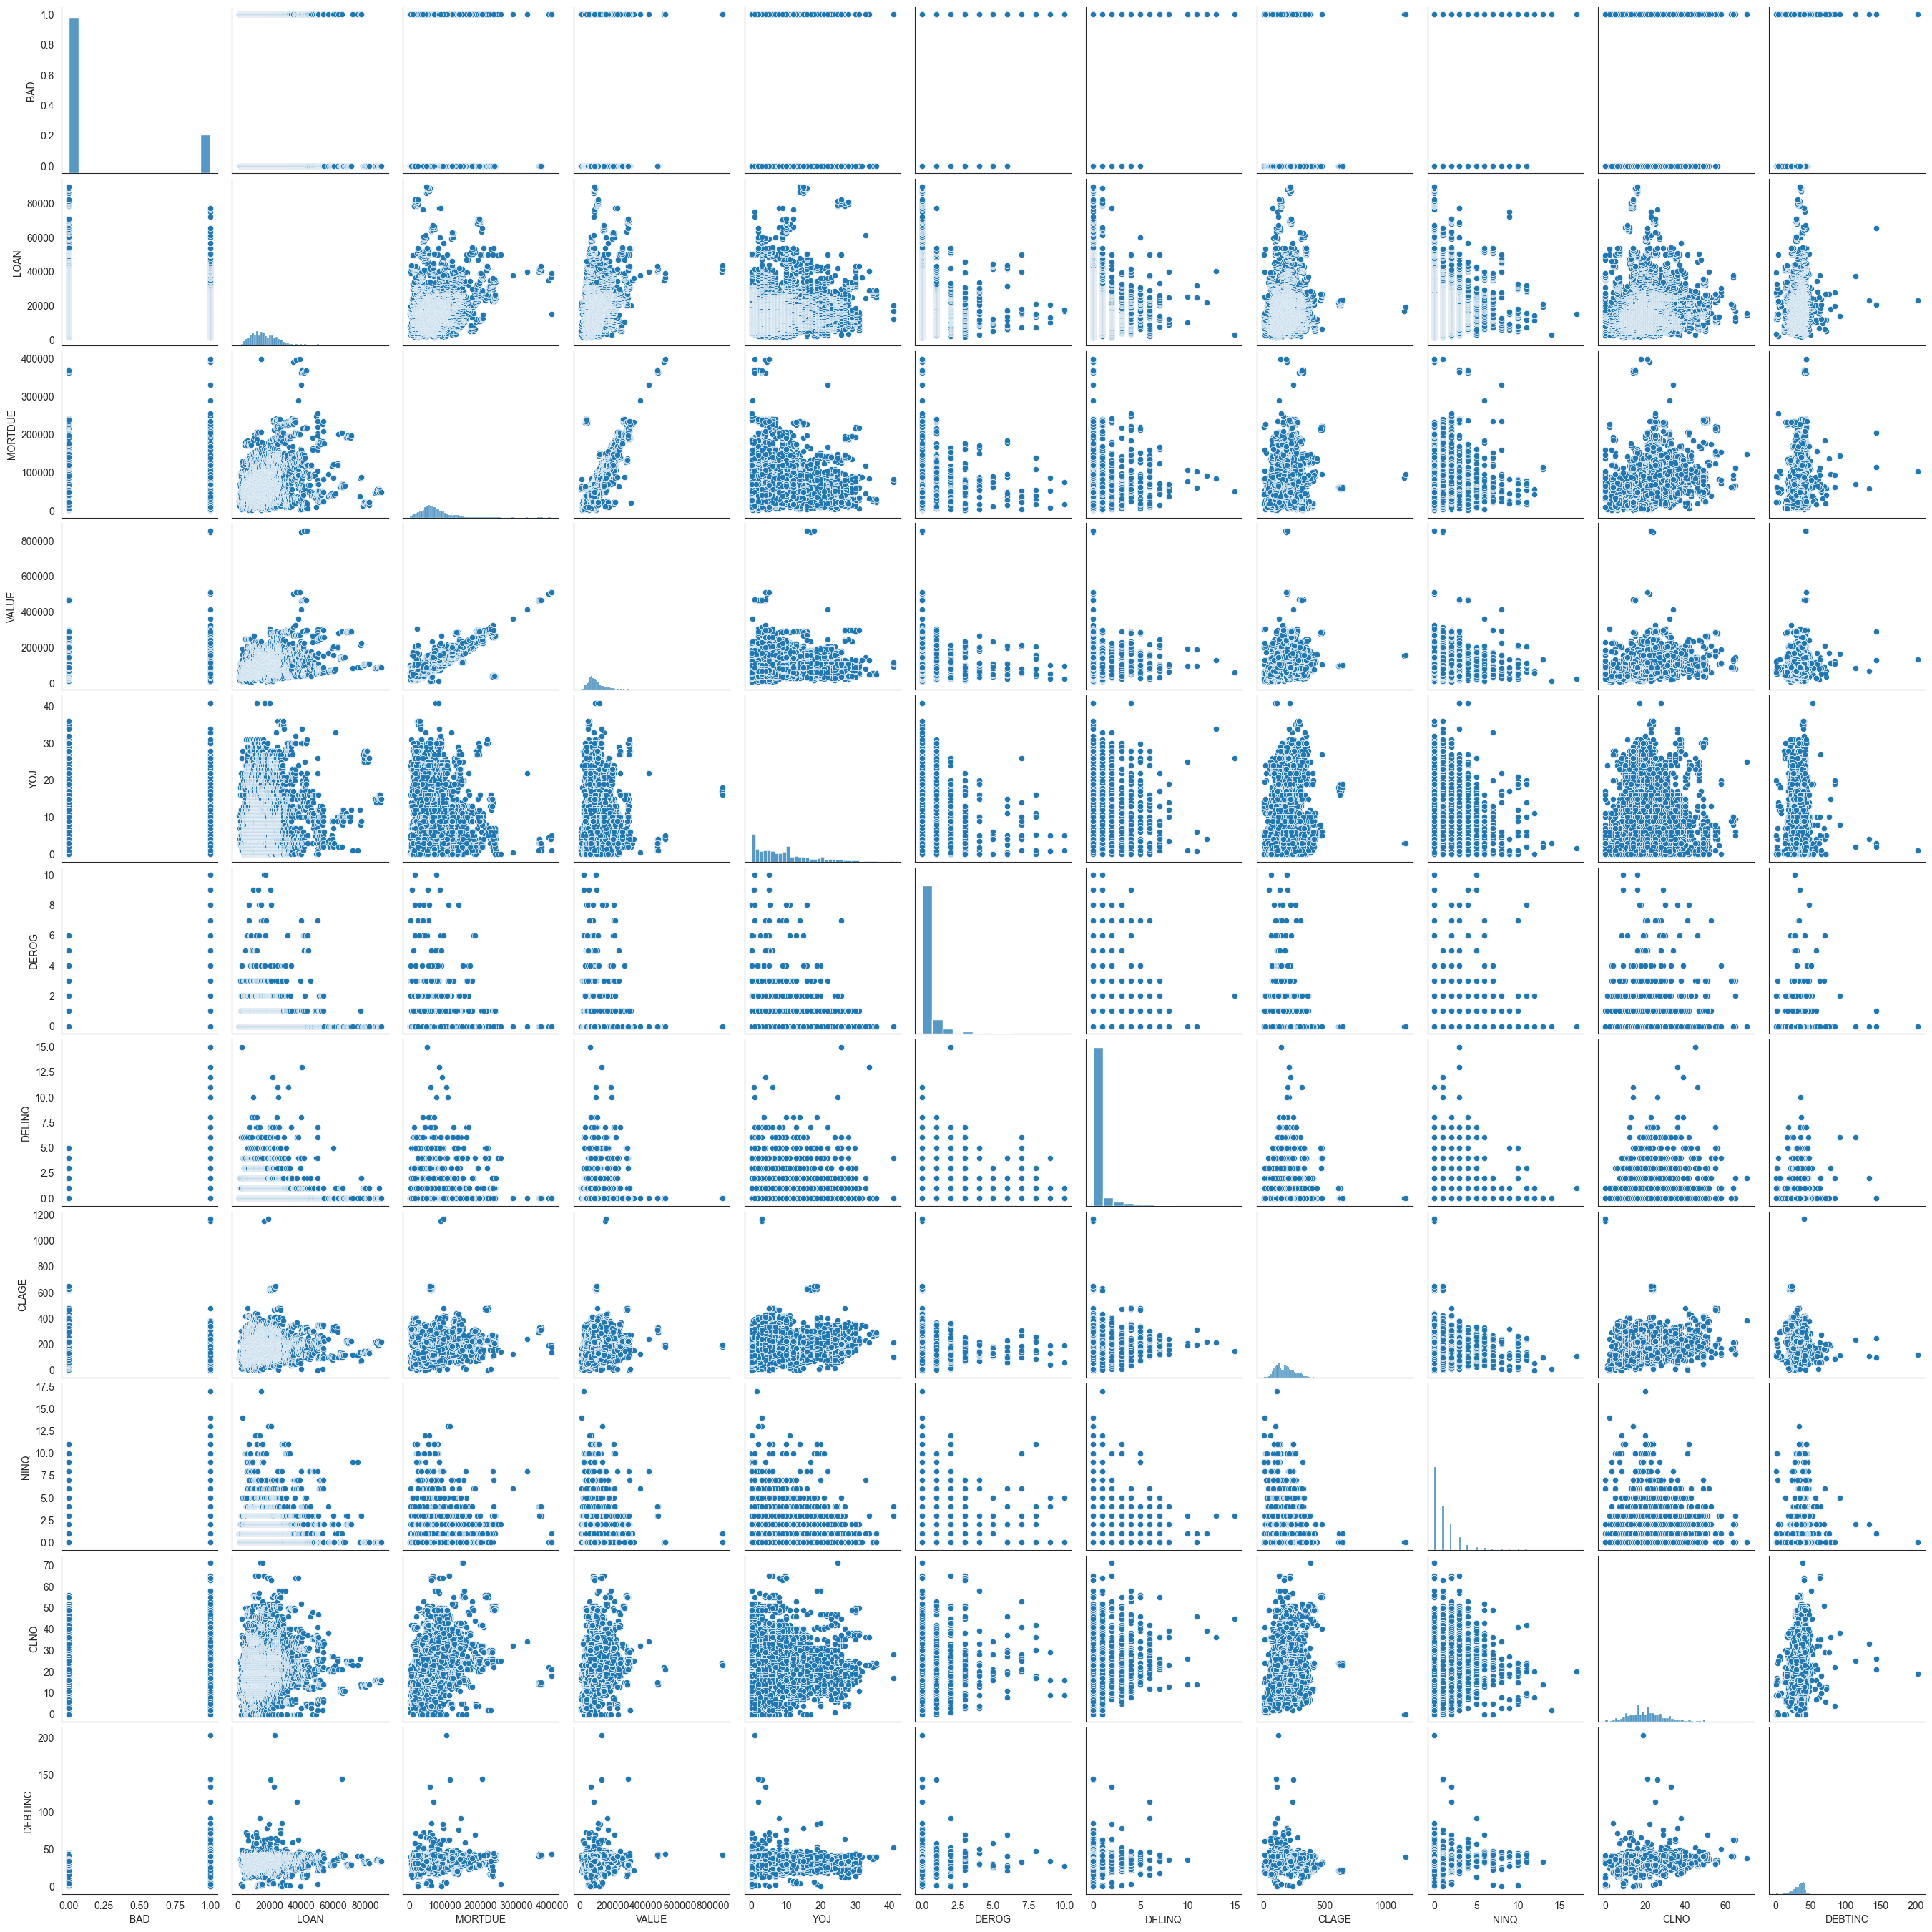

In [48]:
import seaborn as sns
sns.pairplot(df)

In [10]:
def missing_values_summary(data):
    missing_sum = data.isnull().sum()
    missing_percentage = (missing_sum / len(data))
    missing_data = pd.DataFrame({
        'Nombre de valeurs manquantes': missing_sum,
        'Pourcentages de valeurs manquantes': missing_percentage
    })

    return missing_data
missing_values = missing_values_summary(df)
print(missing_values)

         Nombre de valeurs manquantes  Pourcentages de valeurs manquantes
BAD                                 0                            0.000000
LOAN                                0                            0.000000
MORTDUE                           518                            0.086913
VALUE                             112                            0.018792
REASON                            252                            0.042282
JOB                               279                            0.046812
YOJ                               515                            0.086409
DEROG                             708                            0.118792
DELINQ                            580                            0.097315
CLAGE                             308                            0.051678
NINQ                              510                            0.085570
CLNO                              222                            0.037248
DEBTINC                          1267 

In [11]:
df.isna().mean()*100

BAD         0.000000
LOAN        0.000000
MORTDUE     8.691275
VALUE       1.879195
REASON      4.228188
JOB         4.681208
YOJ         8.640940
DEROG      11.879195
DELINQ      9.731544
CLAGE       5.167785
NINQ        8.557047
CLNO        3.724832
DEBTINC    21.258389
dtype: float64

In [12]:
# Vérification des déséquilibres de classes
bad_counts = df['BAD'].value_counts()
print("Déséquilibre des classes de la variable 'BAD' :")
print(bad_counts)

Déséquilibre des classes de la variable 'BAD' :
BAD
0    4771
1    1189
Name: count, dtype: int64


In [13]:
# Analyse de l'équilibre des classes de la variable cible "BAD"
print("\nDistribution de la variable cible 'BAD':")
print(df['BAD'].value_counts(normalize=True))


Distribution de la variable cible 'BAD':
BAD
0    0.800503
1    0.199497
Name: proportion, dtype: float64


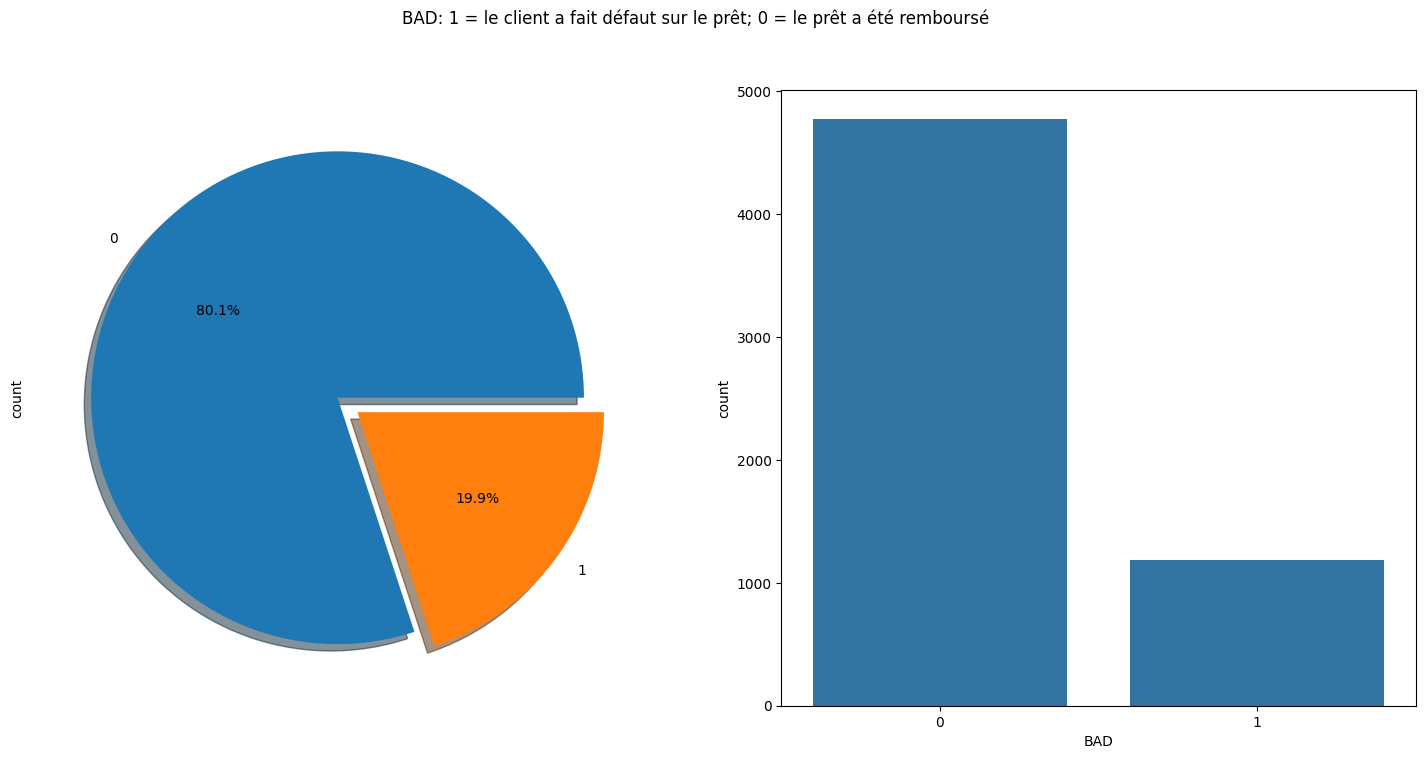

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
t = f.suptitle("BAD: 1 = le client a fait défaut sur le prêt; 0 = le prêt a été remboursé", fontsize=12)

df["BAD"].value_counts().plot.pie(explode=[0, 0.1], autopct="%1.1f%%", ax=ax1, shadow=True)

sns.countplot(x="BAD", data=df, ax=ax2) 

plt.show()


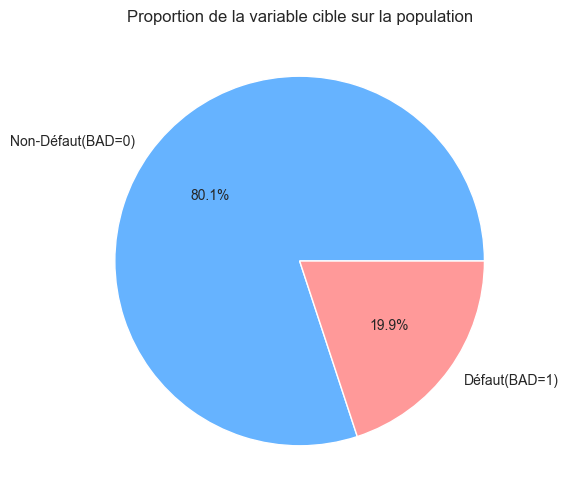

In [15]:
sns.set_style("whitegrid")


counts = df['BAD'].value_counts()
labels = ['Non-Défaut(BAD=0)', 'Défaut(BAD=1)']
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
plt.title('Proportion de la variable cible sur la population')
plt.show()

<Axes: ylabel='Frequency'>

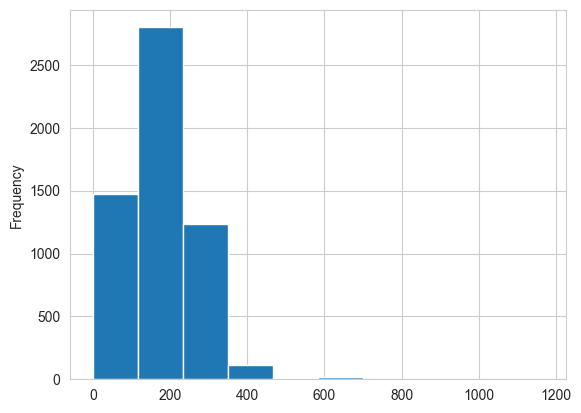

In [16]:
df.CLAGE.plot(kind='hist')

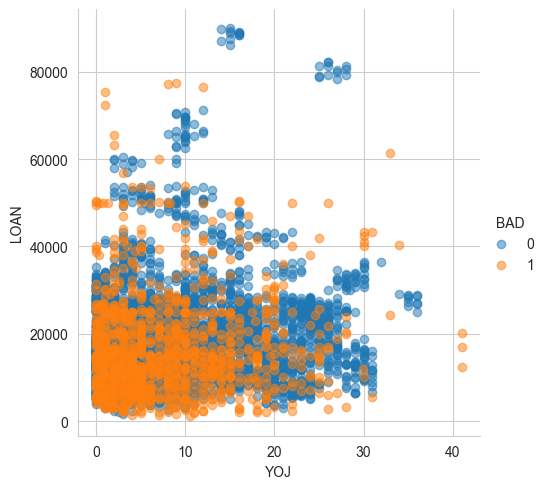

In [17]:
sns.lmplot(x='YOJ', y='LOAN', hue='BAD', data=df, fit_reg=False, scatter_kws={'alpha':0.5});


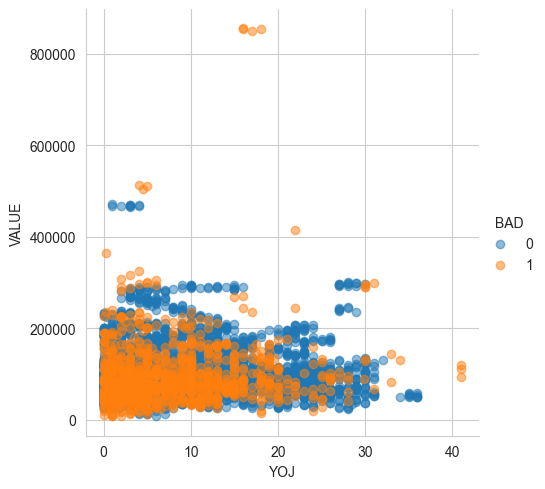

In [18]:
sns.lmplot(x='YOJ', y='VALUE', hue='BAD', data=df, fit_reg=False, scatter_kws={'alpha':0.5});

<Axes: title={'center': 'VALUE'}, xlabel='JOB'>

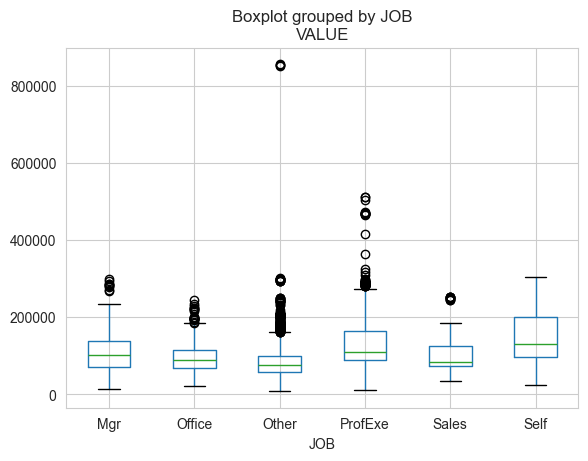

In [19]:
df.boxplot(column='VALUE', by ='JOB')

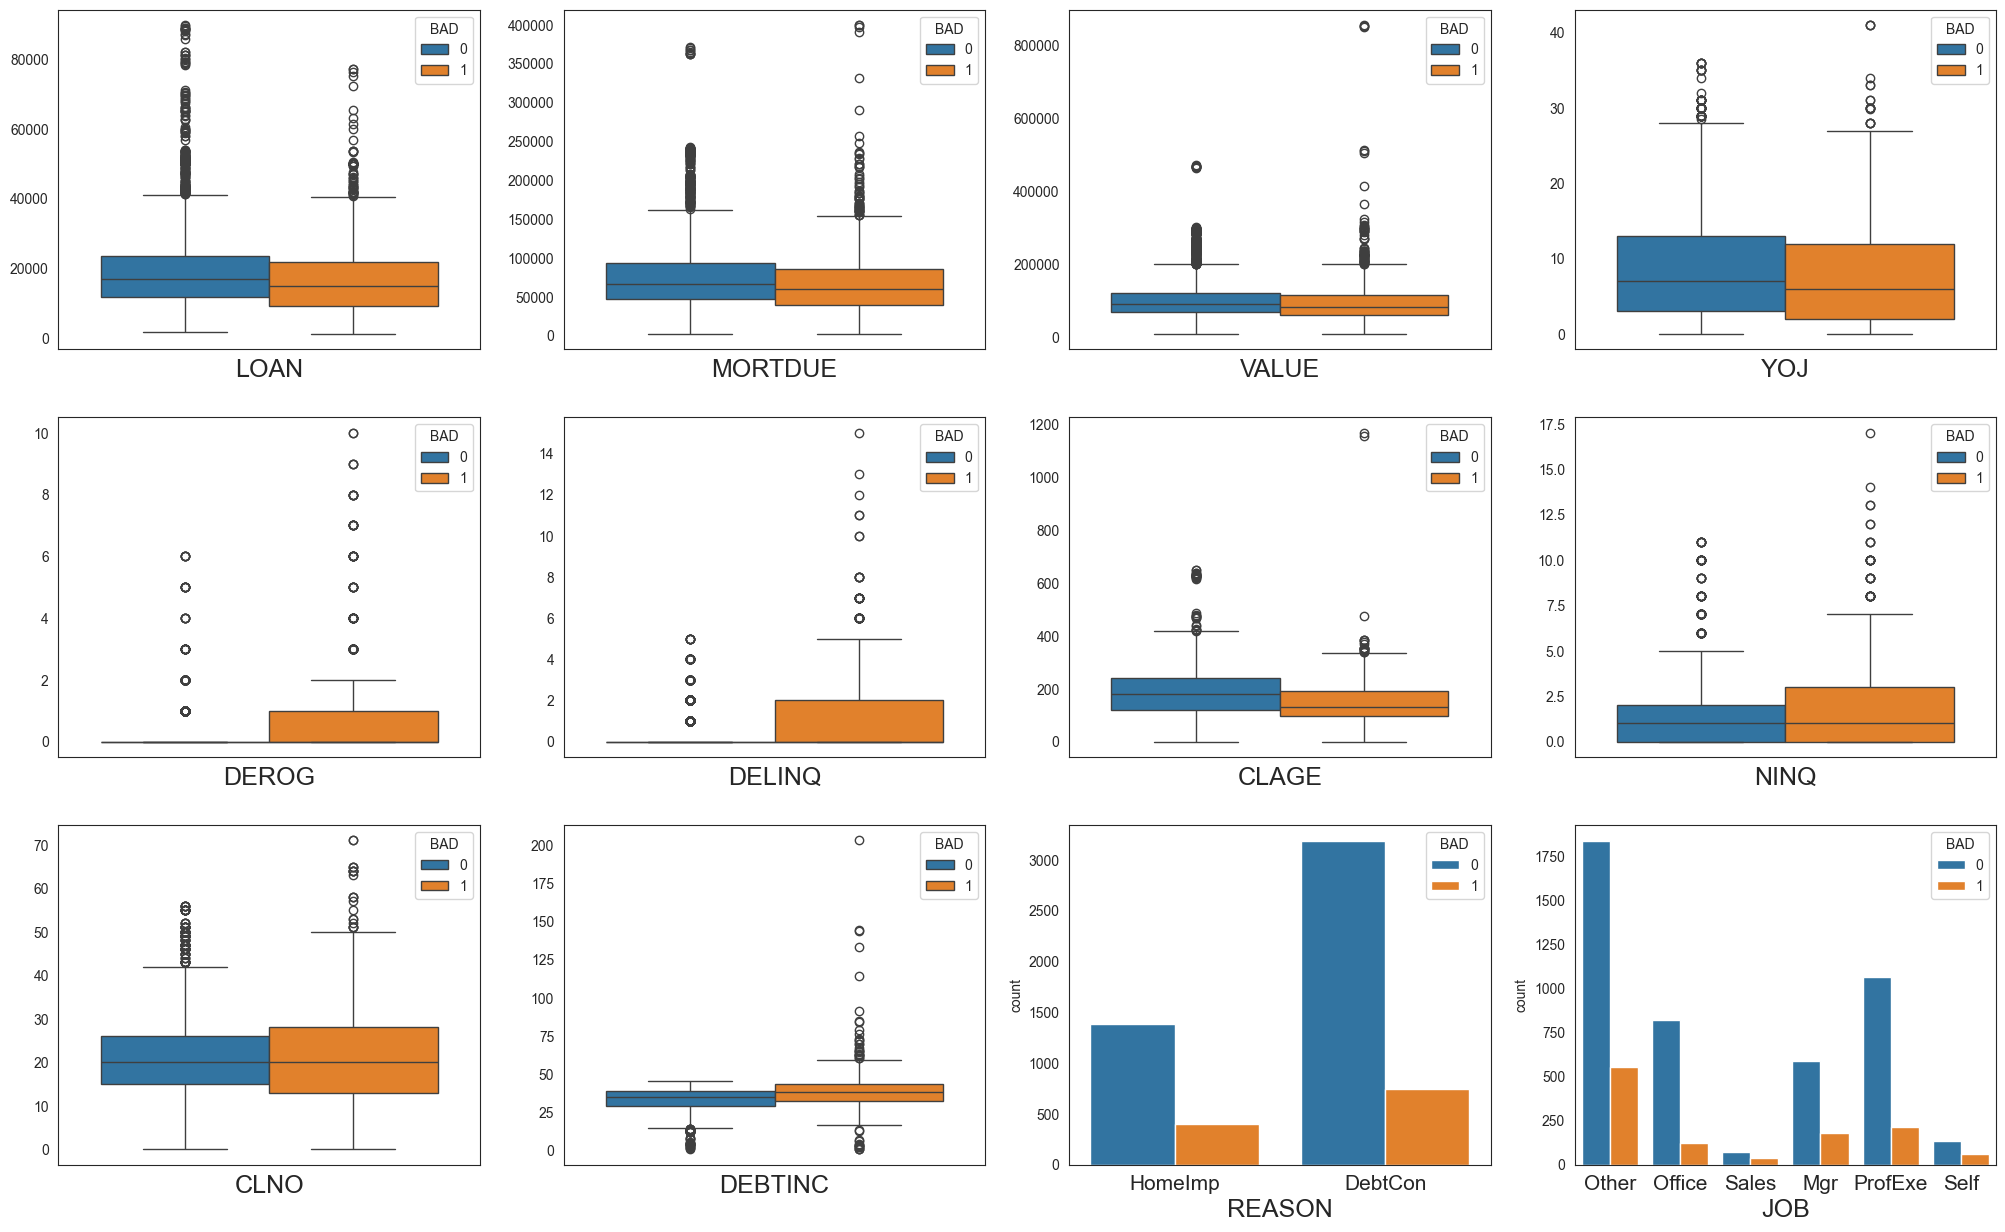

In [20]:
data1=df[['BAD','LOAN']];data2=df[['BAD','MORTDUE']];data3=df[['BAD','VALUE']];data4=df[['BAD','YOJ']];data5=df[['BAD','DEROG']]
data6=df[['BAD','DELINQ']];data7=df[['BAD','CLAGE']];data8=df[['BAD','NINQ']];data9=df[['BAD','CLNO']];data10=df[['BAD','DEBTINC']];
data1=pd.melt(data1,id_vars="BAD",var_name="features",value_name='value')
data2=pd.melt(data2,id_vars="BAD",var_name="features",value_name='value')
data3=pd.melt(data3,id_vars="BAD",var_name="features",value_name='value')
data4=pd.melt(data4,id_vars="BAD",var_name="features",value_name='value')
data5=pd.melt(data5,id_vars="BAD",var_name="features",value_name='value')
data6=pd.melt(data6,id_vars="BAD",var_name="features",value_name='value')
data7=pd.melt(data7,id_vars="BAD",var_name="features",value_name='value')
data8=pd.melt(data8,id_vars="BAD",var_name="features",value_name='value')
data9=pd.melt(data9,id_vars="BAD",var_name="features",value_name='value')
data10=pd.melt(data10,id_vars="BAD",var_name="features",value_name='value')

plt.figure(figsize=(25,15))
sns.set_style("white")
plt.subplot(3,4,1)
a1 = sns.boxplot(x="features", y="value", hue="BAD", data=data1)
a1.set(xlabel=None,ylabel=None)
a1.set_xticklabels(a1.get_xmajorticklabels(), fontsize = 18)
plt.subplot(3,4,2)
a2 = sns.boxplot(x="features", y="value", hue="BAD", data=data2)
a2.set(xlabel=None,ylabel=None)
a2.set_xticklabels(a2.get_xmajorticklabels(), fontsize = 18)
plt.subplot(3,4,3)
a3 = sns.boxplot(x="features", y="value", hue="BAD", data=data3)
a3.set(xlabel=None,ylabel=None)
a3.set_xticklabels(a3.get_xmajorticklabels(), fontsize = 18)
plt.subplot(3,4,4)
a4 = sns.boxplot(x="features", y="value", hue="BAD", data=data4)
a4.set(xlabel=None,ylabel=None)
a4.set_xticklabels(a4.get_xmajorticklabels(), fontsize = 18)
plt.subplot(3,4,5)
a5 = sns.boxplot(x="features", y="value", hue="BAD", data=data5)
a5.set(xlabel=None,ylabel=None)
a5.set_xticklabels(a5.get_xmajorticklabels(), fontsize = 18)
plt.subplot(3,4,6)
a6 = sns.boxplot(x="features", y="value", hue="BAD", data=data6)
a6.set(xlabel=None,ylabel=None)
a6.set_xticklabels(a6.get_xmajorticklabels(), fontsize = 18)
plt.subplot(3,4,7)
a7 = sns.boxplot(x="features", y="value", hue="BAD", data=data7)
a7.set(xlabel=None,ylabel=None)
a7.set_xticklabels(a7.get_xmajorticklabels(), fontsize = 18)
plt.subplot(3,4,8)
a8 = sns.boxplot(x="features", y="value", hue="BAD", data=data8)
a8.set(xlabel=None,ylabel=None)
a8.set_xticklabels(a8.get_xmajorticklabels(), fontsize = 18)
plt.subplot(3,4,9)
a9 = sns.boxplot(x="features", y="value", hue="BAD", data=data9)
a9.set(xlabel=None,ylabel=None)
a9.set_xticklabels(a9.get_xmajorticklabels(), fontsize = 18)
plt.subplot(3,4,10)
a10 = sns.boxplot(x="features", y="value", hue="BAD", data=data10)
a10.set(xlabel=None,ylabel=None)
a10.set_xticklabels(a10.get_xmajorticklabels(), fontsize = 18)
plt.subplot(3,4,11)
a11 = sns.countplot(x='REASON',hue='BAD',data=df)
a11.set_xticklabels(a11.get_xmajorticklabels(), fontsize = 15)
a11.set_xlabel(a11.get_xlabel(), fontsize=18)
plt.subplot(3,4,12)
a12 = sns.countplot(x='JOB',hue='BAD',data=df)
a12.set_xticklabels(a12.get_xmajorticklabels(), fontsize = 15)
a12.set_xlabel(a12.get_xlabel(), fontsize=18)
plt.show()

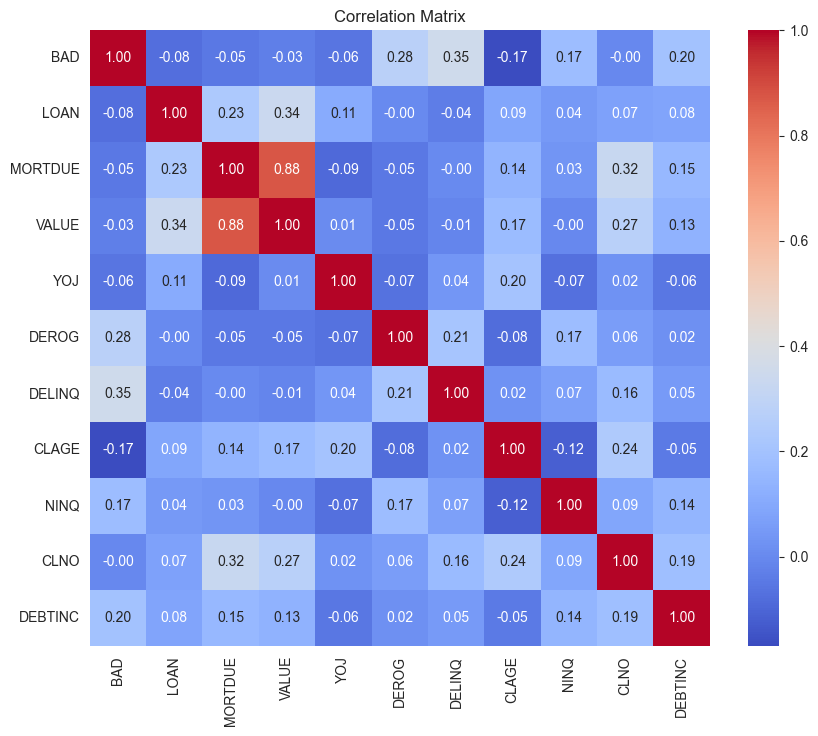

In [52]:
df_coor = num_cols.corr()
df_coor

plt.figure(figsize=(10, 8))
sns.heatmap(df_coor, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [21]:
df.nunique()

BAD           2
LOAN        540
MORTDUE    5053
VALUE      5381
REASON        2
JOB           6
YOJ          99
DEROG        11
DELINQ       14
CLAGE      5314
NINQ         16
CLNO         62
DEBTINC    4693
dtype: int64

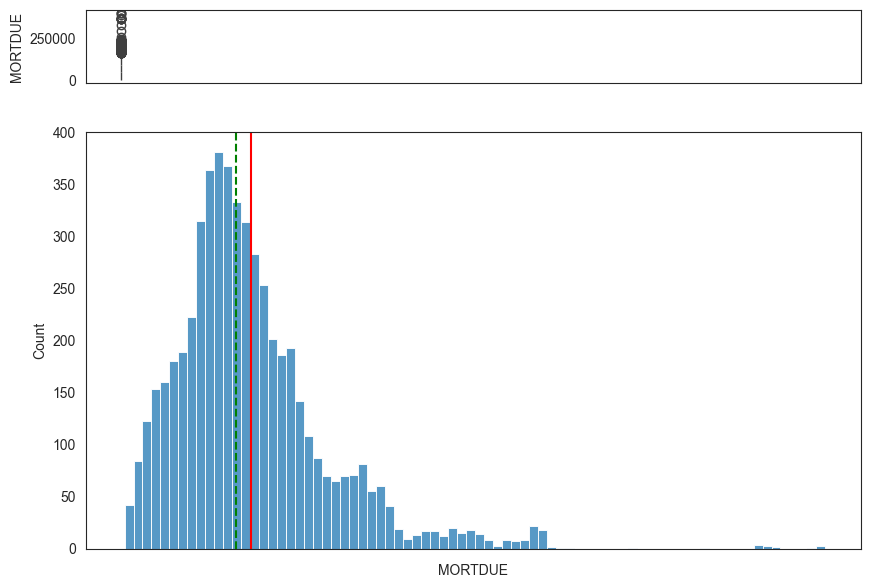

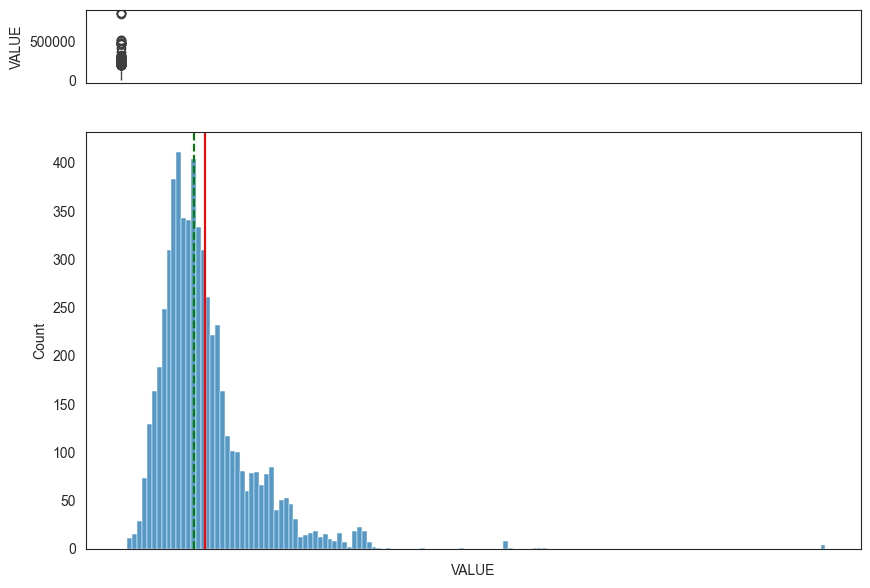

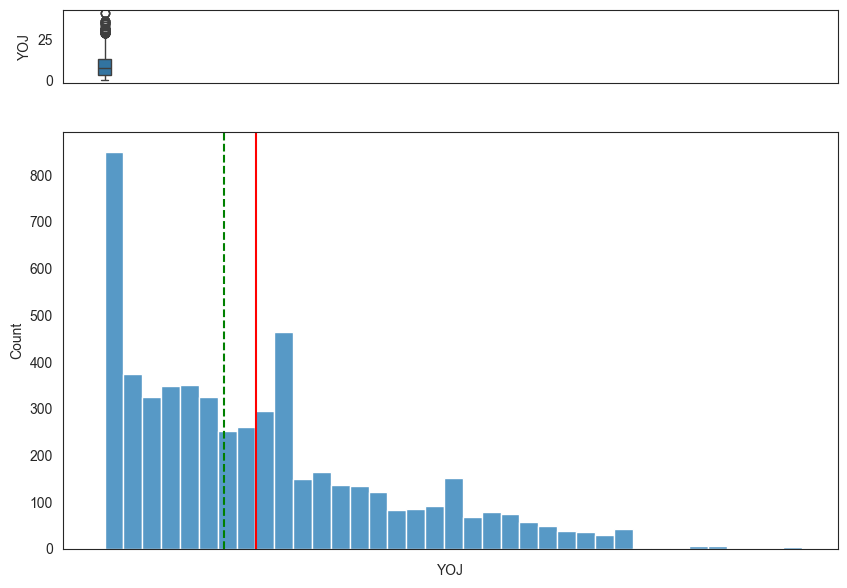

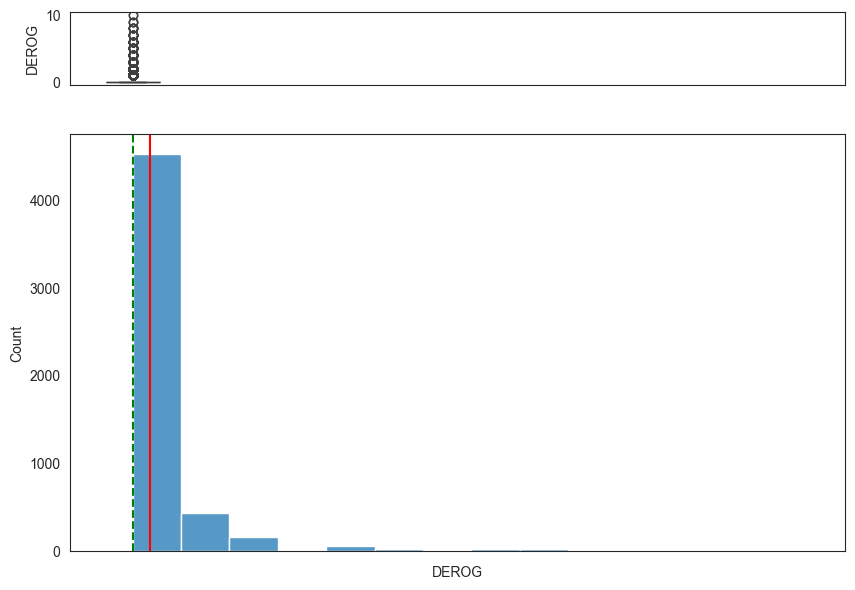

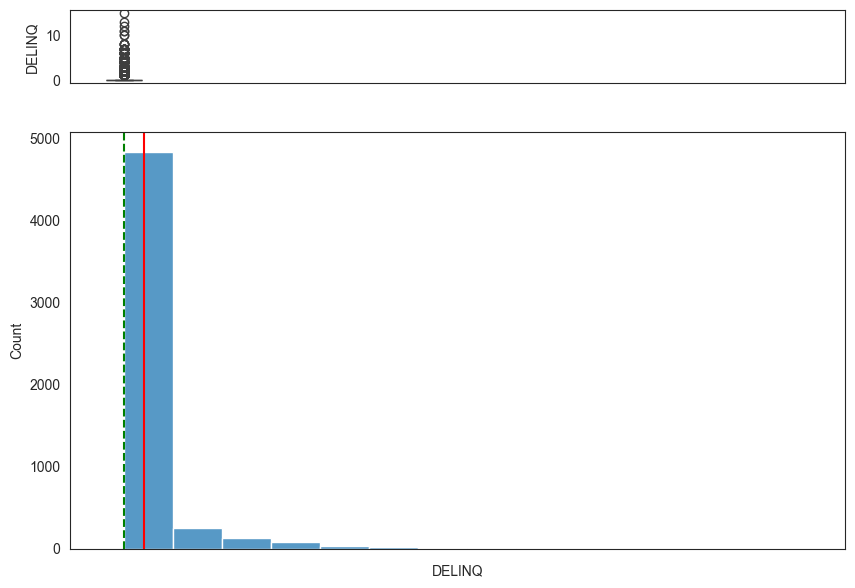

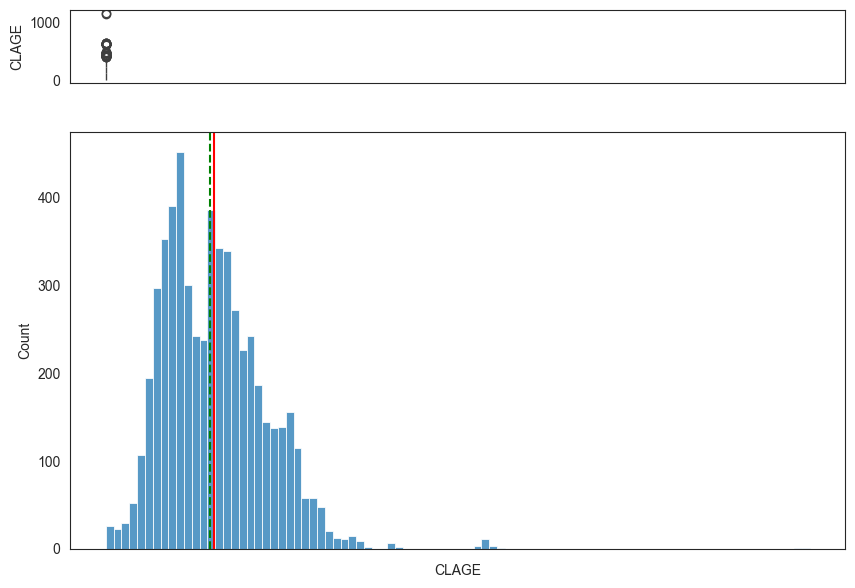

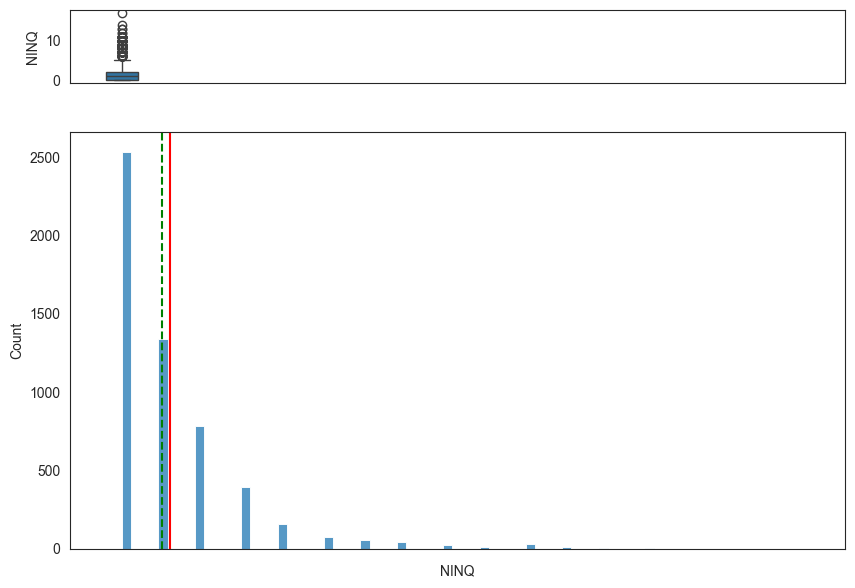

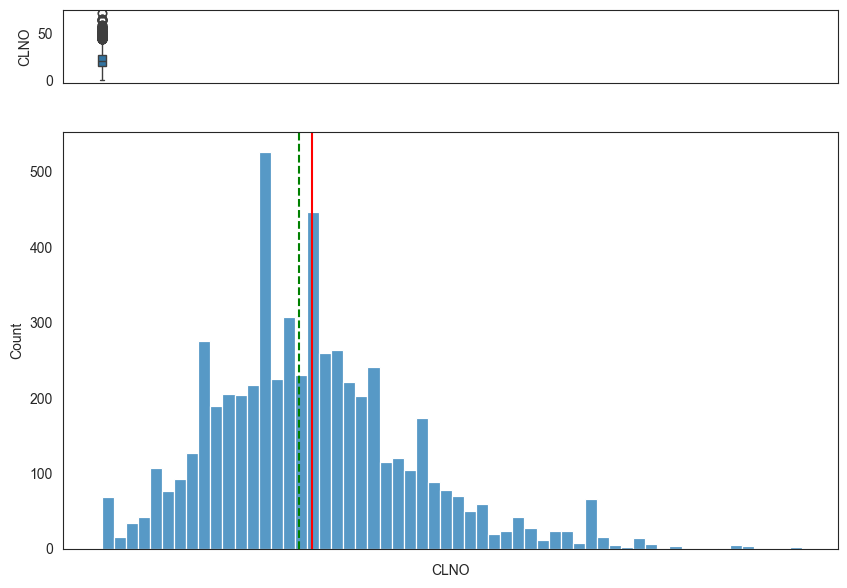

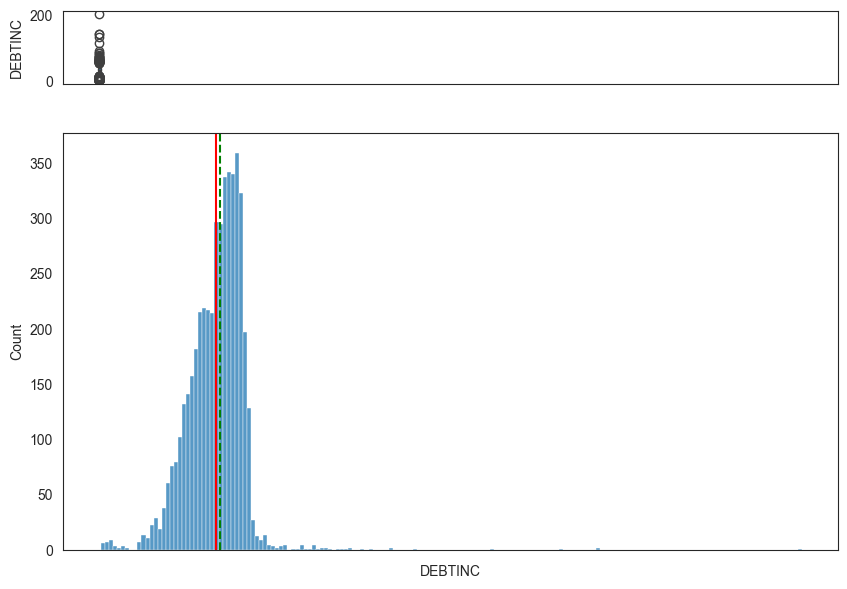

In [ ]:
for TARGET in df.select_dtypes(include=['float64']):  # Itérer sur chaque colonne de type float64
    plt.rcParams["figure.figsize"] = (10,7)  # Définir la taille de la figure pour les graphiques
    
    # Créer une figure composée de deux sous-graphiques (ax_box et ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # Tracer un boxplot pour la variable cible (ax_box)
    sns.boxplot(df[TARGET], ax=ax_box)
    
    # Tracer un histogramme pour la variable cible (ax_hist)
    sns.histplot(df[TARGET], ax=ax_hist)

    # Dessiner la moyenne (en rouge) et la médiane (en vert avec une ligne pointillée)
    plt.axvline(x=df[TARGET].mean(), color='red')  # Moyenne
    plt.axvline(x=df[TARGET].median(), color='green', linestyle='--')  # Médiane

    # Supprimer le nom de l'axe x pour le boxplot
    ax_box.set(xlabel='')

    # Afficher le graphique
    plt.show()


<Axes: xlabel='BAD', ylabel='count'>

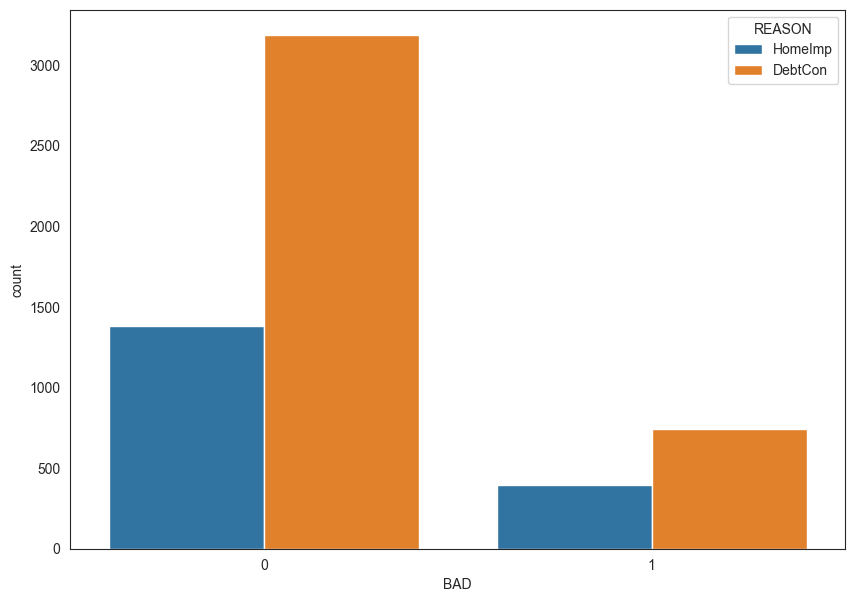

In [23]:
sns.countplot(x= "BAD", data= df, hue="REASON")

<Axes: xlabel='BAD', ylabel='count'>

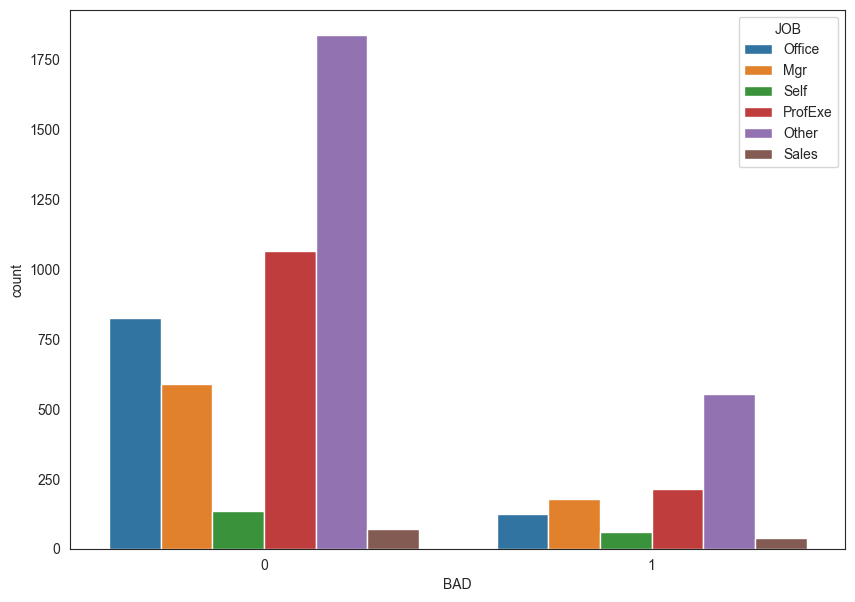

In [24]:
sns.countplot(x= "BAD", data= df, hue="JOB")

#### Analyse des Variables

##### 1. Variable BAD (Variable Cible)
- **Valeurs uniques :** 2  
- Confirme que BAD est une variable de classification binaire (0 ou 1).  
- **Possibilité de déséquilibre ?** Vérifier la distribution (`df['BAD'].value_counts()`) pour voir si une classe domine.  

---

##### 2. Variables Numériques à Haute Cardinalité (Variables Continues)

| Colonne  | Valeurs Uniques | Interprétation |
|----------|----------------|---------------|
| LOAN     | 540            | Montant du prêt → variable continue. |
| MORTDUE  | 5053           | Montant hypothécaire → très variable. |
| VALUE    | 5381           | Valeur du bien → unique pour chaque emprunteur. |
| CLAGE    | 5314           | Ancienneté de la ligne de crédit la plus ancienne → peut nécessiter une transformation (log si asymétrique). |
| DEBTINC  | 4693           | Ratio dette/revenu → continue. |

**Implications :**  
- Ces variables sont continues et ne doivent **pas** être one-hot encodées.  
- Normalisation (MinMaxScaler) ou standardisation (StandardScaler) nécessaire pour les modèles sensibles à l’échelle (ex : régression logistique).  

---

##### 3. Variables Catégoriques

| Colonne  | Valeurs Uniques | Interprétation |
|----------|----------------|---------------|
| REASON   | 2              | Variable catégorique binaire (peut être encodée en 0/1). |
| JOB      | 6              | Variable catégorique (peut être encodée en one-hot si pas d’ordre hiérarchique). |

**Implications :**  
- **REASON** → Encodage one-hot ou label (0/1).  
- **JOB** → Encodage one-hot (6 catégories sans hiérarchie claire).  

---

##### 4. Variables Numériques Discrètes (Potentiellement Catégoriques)

| Colonne  | Valeurs Uniques | Interprétation |
|----------|----------------|---------------|
| YOJ      | 99             | Années d'ancienneté → Peut être catégorisé (0-5, 6-10, etc.). |
| DEROG    | 11             | Rapports de crédit majeurs → Peut être traité comme ordinal. |
| DELINQ   | 14             | Nombre de défauts de paiement → Peut être regroupé en classes. |
| NINQ     | 16             | Nombre de demandes de crédit → Peut être discretisé (faible, moyen, élevé). |
| CLNO     | 62             | Nombre de lignes de crédit → Peut nécessiter une normalisation. |

**Implications :**  
- **Binning (discrétisation)** peut améliorer l'interprétabilité.  
- **Encodage ordinal** envisageable pour **DEROG, DELINQ, NINQ** si un ordre naturel existe.  

---

##### 5. Variables à Vérifier pour les Valeurs Extrêmes
- **YOJ (Années d'ancienneté)** → Détecter les valeurs extrêmes (0 ans ou valeurs anormalement élevées).  
- **DEBTINC (Ratio Dette/Revenu)** → Vérifier les valeurs extrêmes, appliquer une transformation log ou Winsorisation.  
- **CLAGE (Ancienneté Crédit)** → Vérifier l’asymétrie (personnes avec une ancienneté de crédit très élevée).  

---

##### Synthèse et Étapes Suivantes

**Feature Engineering :**  
- **REASON** (binaire) → Label Encoding (0/1).  
- **JOB** (catégorique) → One-Hot Encoding (6 catégories).  
- **Discrétiser** YOJ, DEROG, DELINQ, NINQ si nécessaire.  

**Gestion des valeurs extrêmes :**  
- Utiliser des **boxplots** et une analyse de **score Z** pour détecter et limiter les valeurs extrêmes dans **LOAN, MORTDUE, VALUE, DEBTINC, CLAGE**.  

**Normalisation & Standardisation :**  
- Variables continues (**MORTDUE, VALUE, CLAGE, DEBTINC**) → Standardisation ou MinMax Scaling si requis.  

**Exploration des Données (EDA) :**  
- Vérifier la distribution des variables catégoriques (**JOB, REASON**).  
- Analyser la **matrice de corrélation** pour éviter les variables redondantes.  


In [25]:
# Vérificationn des valeurs dupliquées
dup=df.duplicated().sum()
print(f"Il y a {dup} valeur(s) dupliquée(s)")

Il y a 0 valeur(s) dupliquée(s)


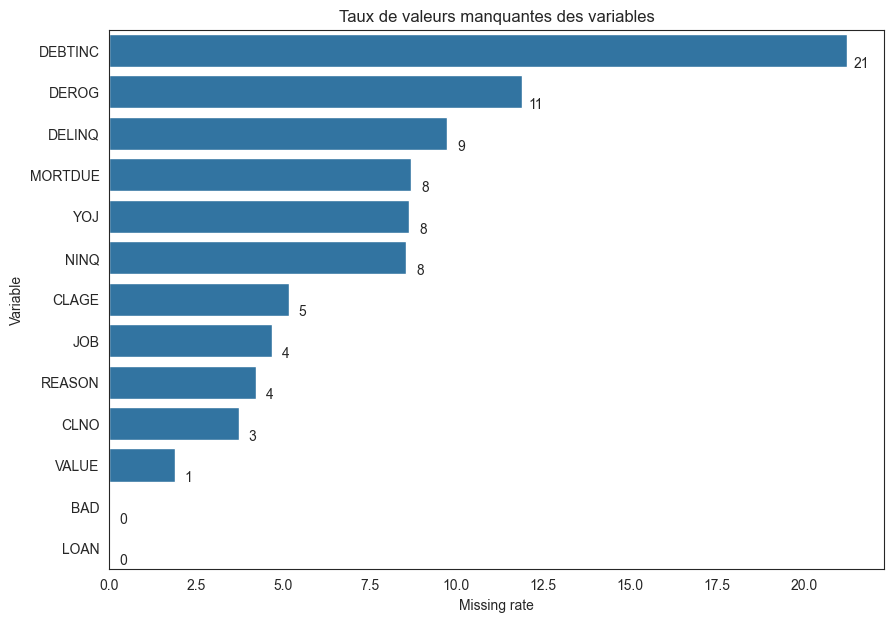

In [28]:
def miss_data(df):
    x = ['Variable','Missing rate','Count of Distinct Values']
    missing_data = pd.DataFrame(columns=x)
    columns = df.columns
    for col in columns:
        icolumn_name = col
        imissing_in_percentage = (df[col].isnull().sum()/df[col].shape[0])*100
        idistinct_values=df[col].nunique()

        missing_data.loc[len(missing_data)] = [icolumn_name, imissing_in_percentage, idistinct_values]
        missing_data.sort_values('Missing rate', ascending=False,inplace=True)
    return missing_data

hmeq_missing = miss_data(df)

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="center")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

fig = sns.barplot(x ='Missing rate', y ='Variable', data = hmeq_missing)
show_values_on_bars(fig,"h",0.4)
plt.title("Taux de valeurs manquantes des variables")
plt.show(fig)

<Axes: >

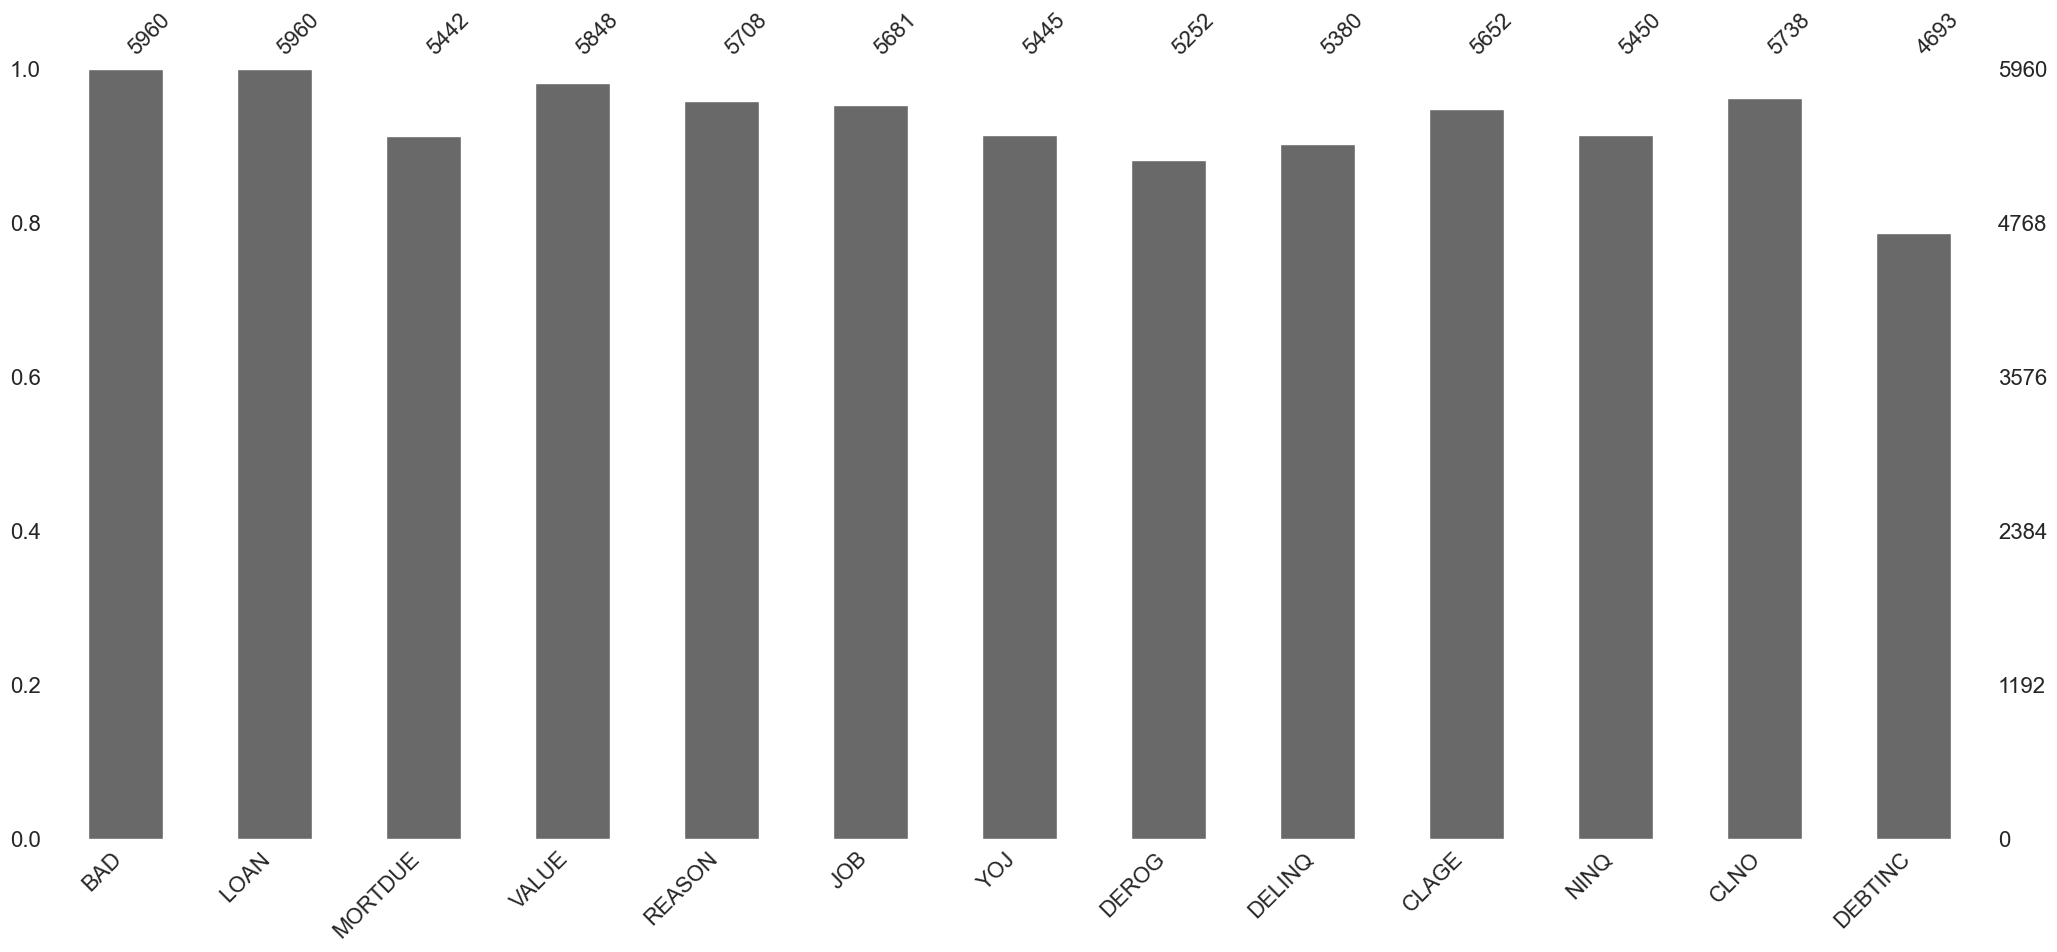

In [29]:
msno.bar(df)

<Axes: >

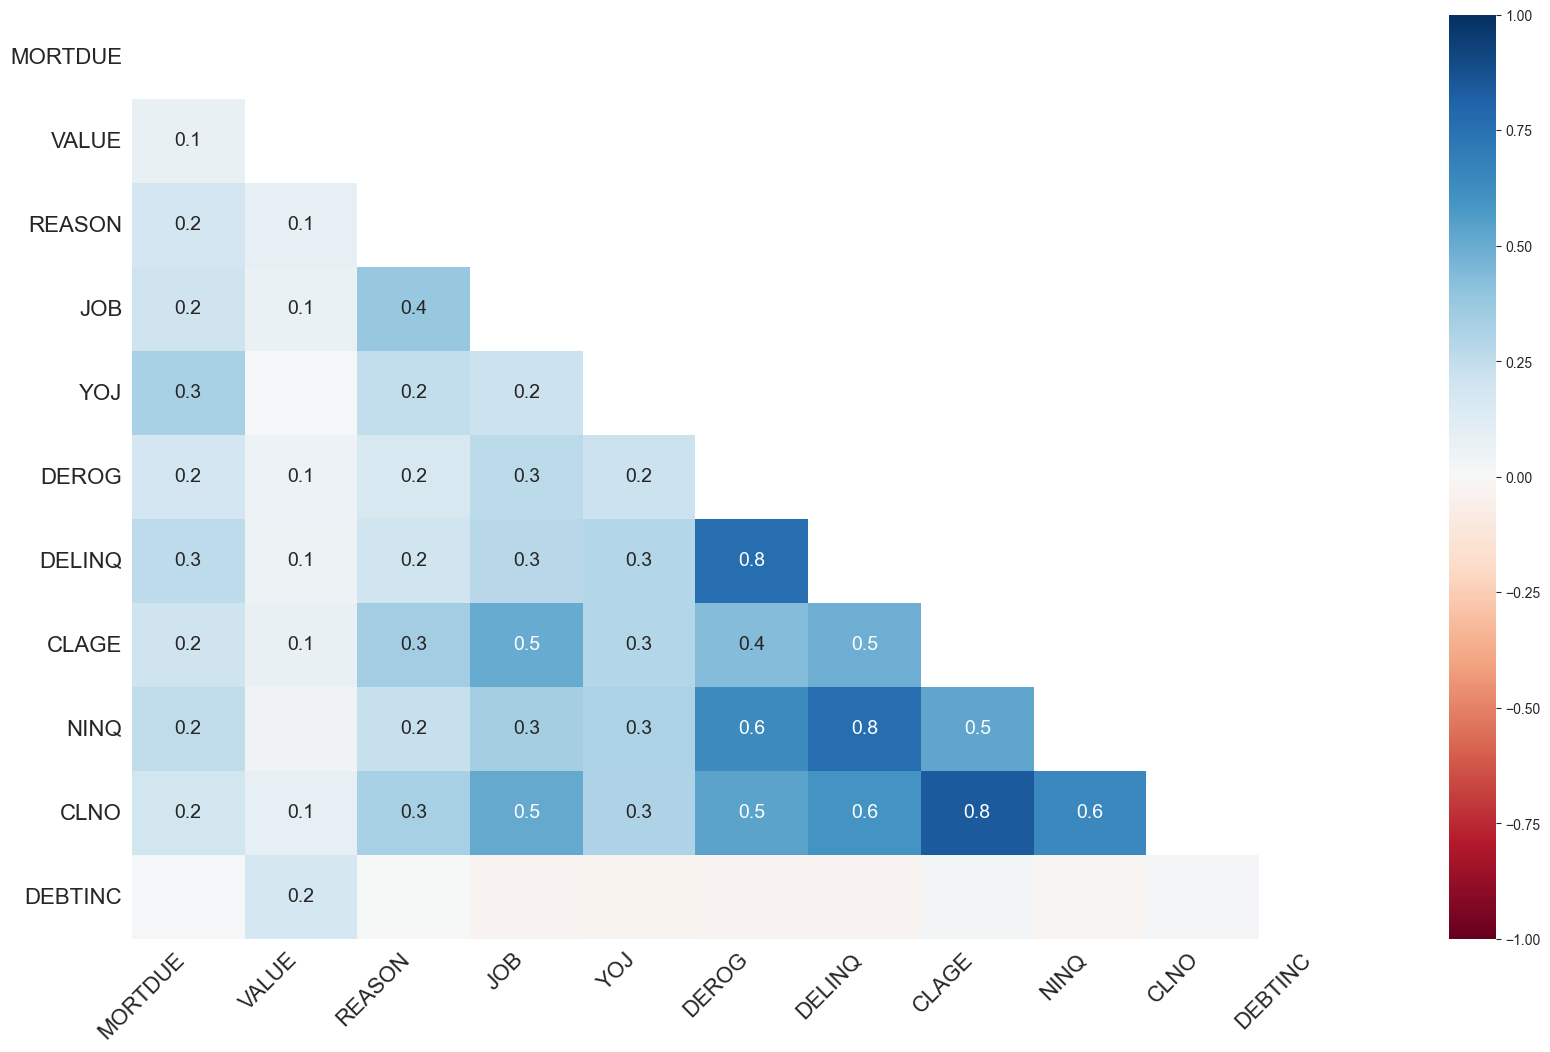

In [30]:
msno.heatmap(df)

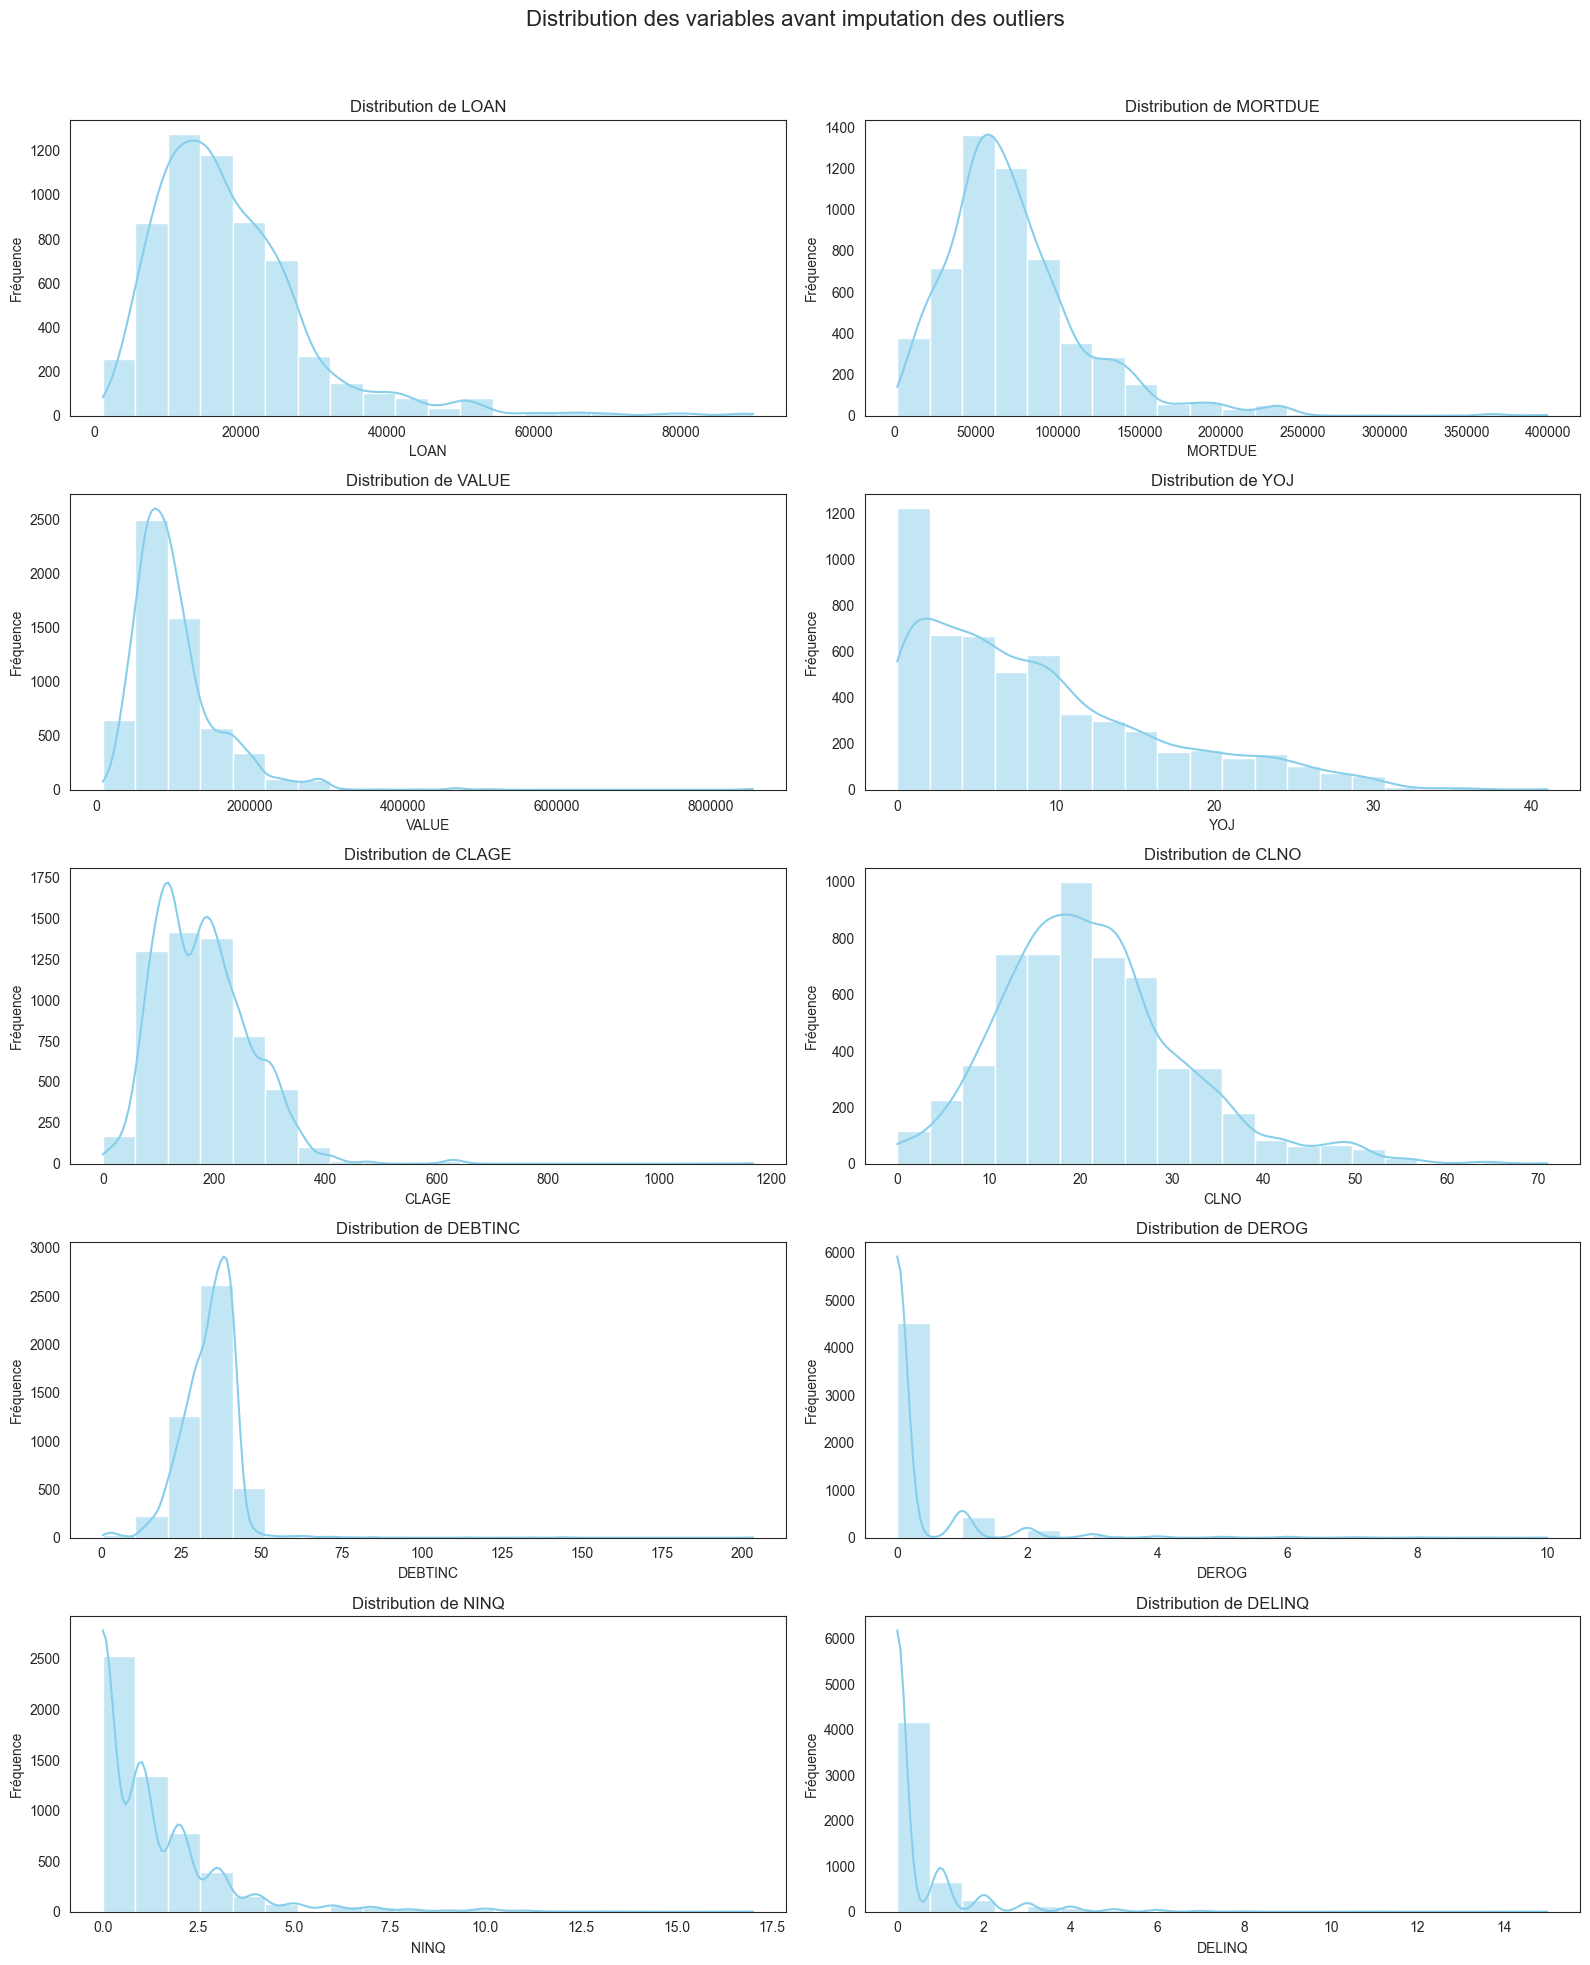

In [31]:
num_col = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'CLNO', 'DEBTINC', 'DEROG', 'NINQ', 'DELINQ']


fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))
fig.suptitle('Distribution des variables avant imputation des outliers', fontsize=16)

for i, col in enumerate(num_col):
    row = i // 2
    col_position = i % 2
    ax = axes[row, col_position]
    sns.histplot(df[col], bins=20, kde=True, color='skyblue', ax=ax)
    ax.set_title(f'Distribution de {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Fréquence')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Analyse bivariée pour les variables catégorielles

In [32]:
categorical_variables = ['REASON', 'JOB']

crosstabs = {}
for var in categorical_variables:
    crosstabs[var] = pd.crosstab(df[var], df['BAD'])
    print(f"Tableau croisé pour {var}:\n", crosstabs[var], "\n")


Tableau croisé pour REASON:
 BAD         0    1
REASON            
DebtCon  3183  745
HomeImp  1384  396 

Tableau croisé pour JOB:
 BAD         0    1
JOB               
Mgr       588  179
Office    823  125
Other    1834  554
ProfExe  1064  212
Sales      71   38
Self      135   58 



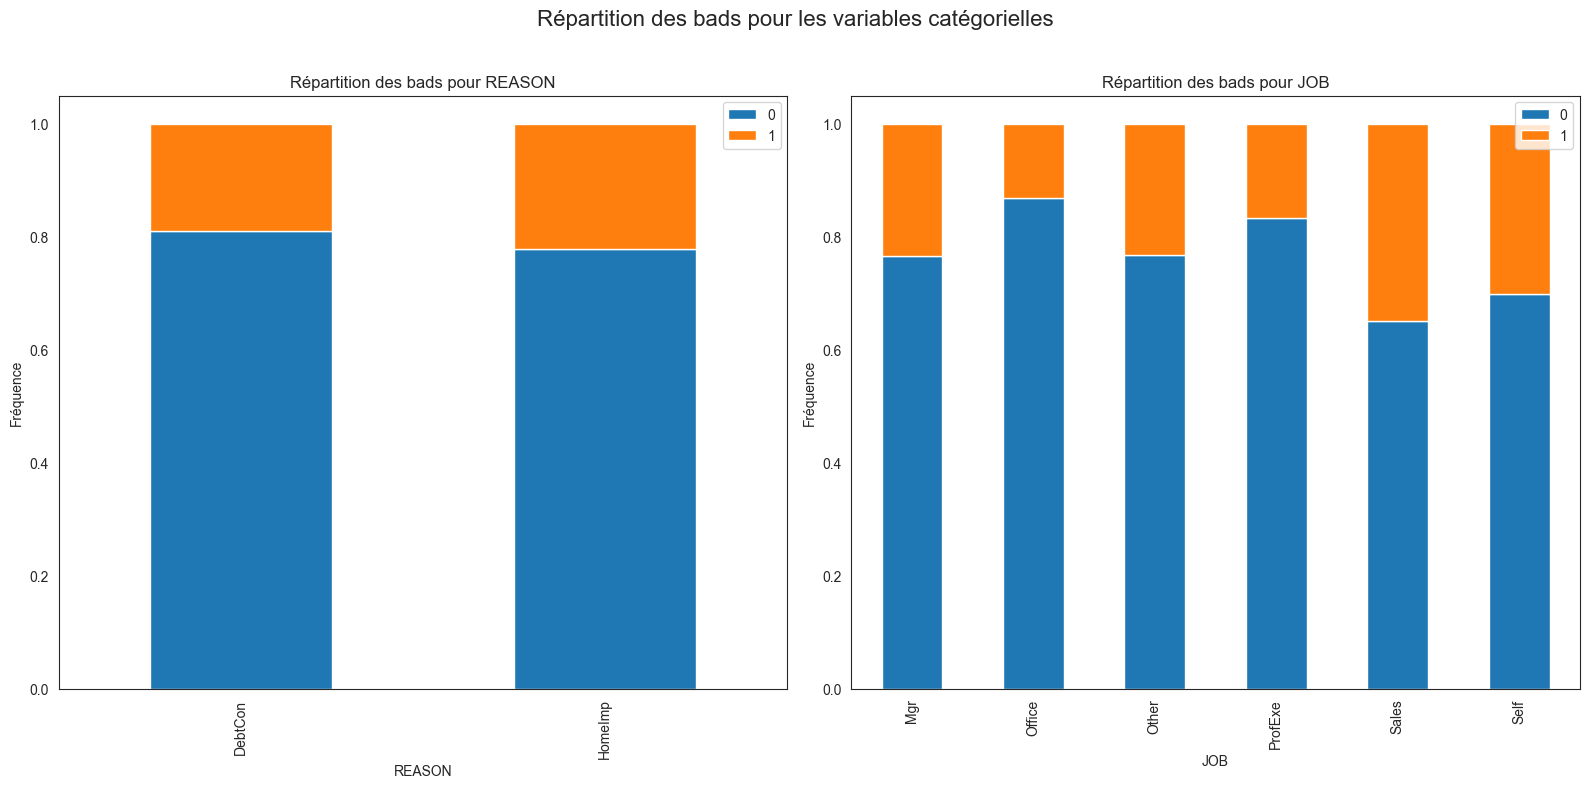

Test du chi-carré pour REASON et BAD :
Statistique de test : 8.039751291499368, p-value : 0.004576181950707232, degrés de liberté : 1

Association entre BAD et REASON : Significative, V de Cramer : 0.038

---------------------------------------------------

Test du chi-carré pour JOB et BAD :
Statistique de test : 81.93248953692773, p-value : 3.306676232858524e-16, degrés de liberté : 5

Association entre BAD et JOB : Significative, V de Cramer : 0.120

---------------------------------------------------



In [34]:
# Graphique pour représenter REASON et JOB

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
fig.suptitle('Répartition des bads pour les variables catégorielles', fontsize=16)

categorical_variables = ['REASON', 'JOB']  # Définir les variables catégorielles à afficher

for i, var in enumerate(categorical_variables):
    ax = axes[i]
    crosstab = pd.crosstab(df[var], df['BAD'], normalize='index')  # Créer un tableau croisé dynamique
    crosstab.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(f'Répartition des bads pour {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Fréquence')
    ax.legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Test du chi-carré pour vérifier l'association entre BAD et les variables catégorielles
association_results = []

for var in categorical_variables:
    crosstab = pd.crosstab(df[var], df['BAD'])
    chi2_stat, p_val, dof, expected = chi2_contingency(crosstab)

    if p_val < 0.05:
        association_strength = "Significative"
    else:
        association_strength = "Non significative"

    # Calcul du V de Cramer pour mesurer la force de l'association
    n = crosstab.sum().sum()
    v_cramer = np.sqrt(chi2_stat / (n * (min(crosstab.shape) - 1)))

    association_results.append((var, 'BAD', association_strength, v_cramer))
    print(f"Test du chi-carré pour {var} et BAD :\nStatistique de test : {chi2_stat}, p-value : {p_val}, degrés de liberté : {dof}\n")
    print(f"Association entre BAD et {var} : {association_strength}, V de Cramer : {v_cramer:.3f}\n")
    print("---------------------------------------------------\n")

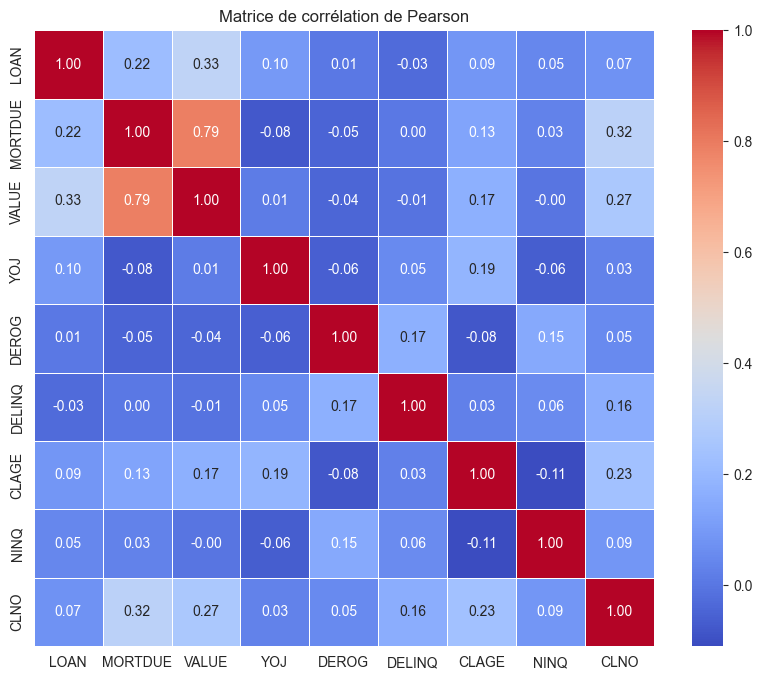

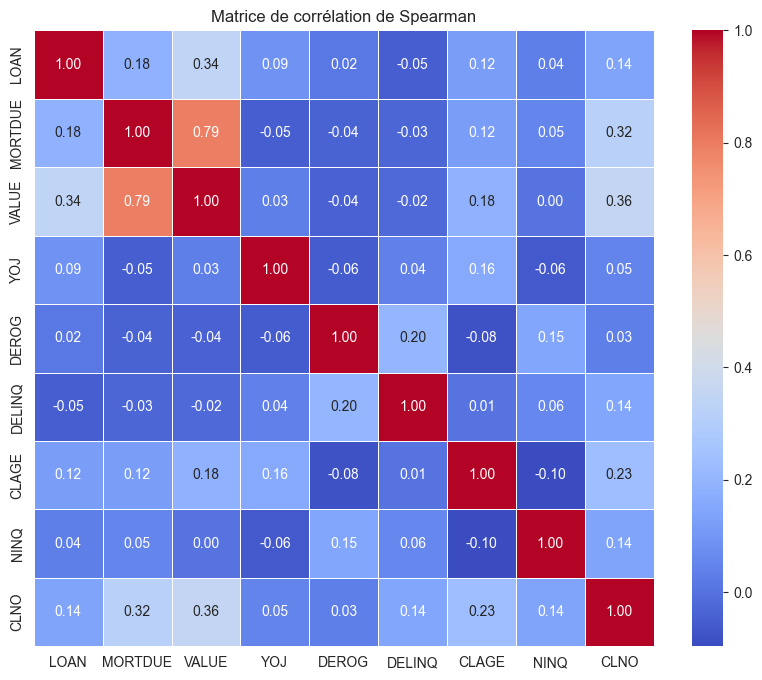

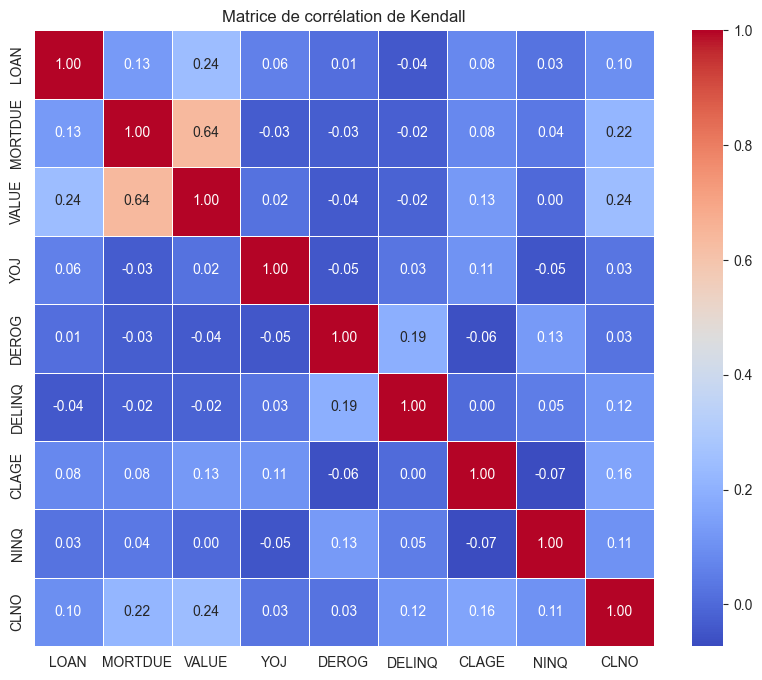

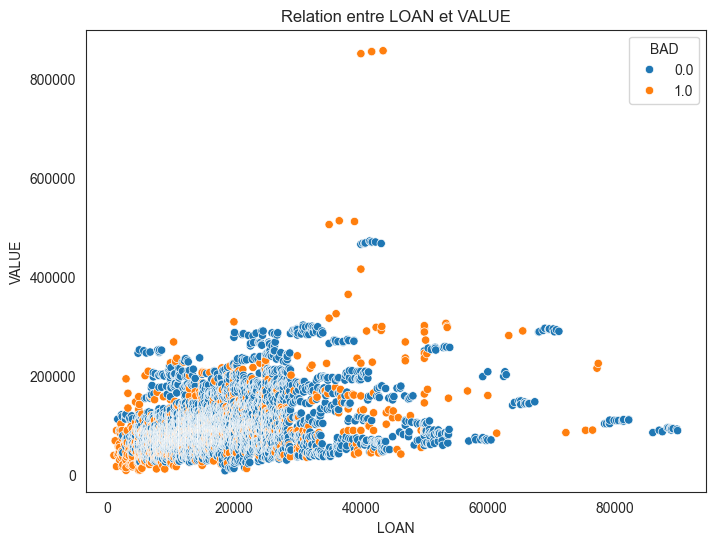

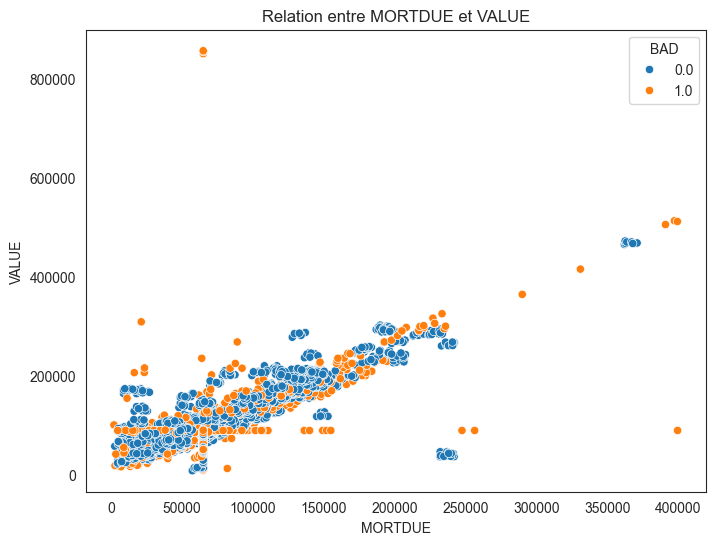

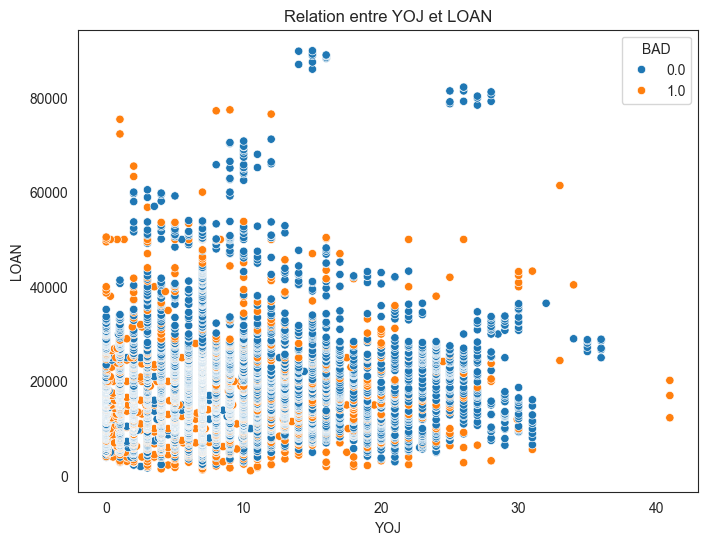

In [57]:
from scipy.stats import pearsonr, spearmanr, kendalltau
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sélectionner les variables numériques d'intérêt
num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO']

# Nettoyer les données : remplacer '?' par NaN et convertir en float
df[num_cols] = df[num_cols].replace('?', np.nan).astype(float)

# Remplir les NaN avec la médiane de chaque colonne
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Calculer la matrice de corrélation de Pearson
pearson_corr = df[num_cols].corr(method='pearson')

# Afficher la matrice de corrélation de Pearson
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation de Pearson')
plt.show()

# Calculer la matrice de corrélation de Spearman
spearman_corr = df[num_cols].corr(method='spearman')

# Afficher la matrice de corrélation de Spearman
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation de Spearman')
plt.show()

# Calculer la matrice de corrélation de Kendall
kendall_corr = df[num_cols].corr(method='kendall')

# Afficher la matrice de corrélation de Kendall
plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation de Kendall')
plt.show()

# Fonction pour afficher les scatterplots entre deux variables
def plot_scatter(df, var1, var2):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=var1, y=var2, hue='BAD', data=df)
    plt.title(f'Relation entre {var1} et {var2}')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()

# Exemple : Afficher les scatterplots pour quelques paires de variables intéressantes
plot_scatter(df, 'LOAN', 'VALUE')
plot_scatter(df, 'MORTDUE', 'VALUE')
plot_scatter(df, 'YOJ', 'LOAN')

* Test du khi deux et v de cramer pour mésurer l'association entre variables catégorielle

* V de cramer : https://lemakistatheux.wordpress.com/2013/05/31/le-v-de-cramer/

Le V de Cramer permet de quantifier l'intensité de l'association, ce qui complète les résultats du test du chi-carré. Même si le test indique une association significative, le V de Cramer montre à quel point cette association est forte ou faible. Cela aide à comprendre l'importance des variables catégorielles pour la modélisation.

In [35]:

def cramers_v(chi2, n, dof):
    return np.sqrt(chi2 / (n * min(dof, n-1)))

categorical_variables = ['BAD','REASON', 'JOB']

association_results = []


for var1, var2 in itertools.combinations(categorical_variables, 2):

    crosstab = pd.crosstab(df[var1], df[var2])

    chi2_stat, p_val, dof, expected = chi2_contingency(crosstab)
    n = crosstab.sum().sum()
    v_cramer = cramers_v(chi2_stat, n, dof)


    if v_cramer < 0.1:
        association_strength = "Faible"
    elif v_cramer < 0.3:
        association_strength = "Modérée"
    elif v_cramer < 0.5:
        association_strength = "Relativement forte"
    else:
        association_strength = "Très forte"


    association_results.append({
        "Variable 1": var1,
        "Variable 2": var2,
        "Chi2 Statistique": round(chi2_stat, 3),
        "p-value": round(p_val, 3),
        "V de Cramer": round(v_cramer, 3),
        "Intensité de l'association": association_strength
    })

association_df = pd.DataFrame(association_results)


association_df


Variable 1 Variable 2  Chi2 Statistique  p-value  V de Cramer  \
0        BAD     REASON             8.040    0.005        0.038   
1        BAD        JOB            81.932    0.000        0.054   
2     REASON        JOB           122.909    0.000        0.067   

  Intensité de l'association  
0                     Faible  
1                     Faible  
2                     Faible

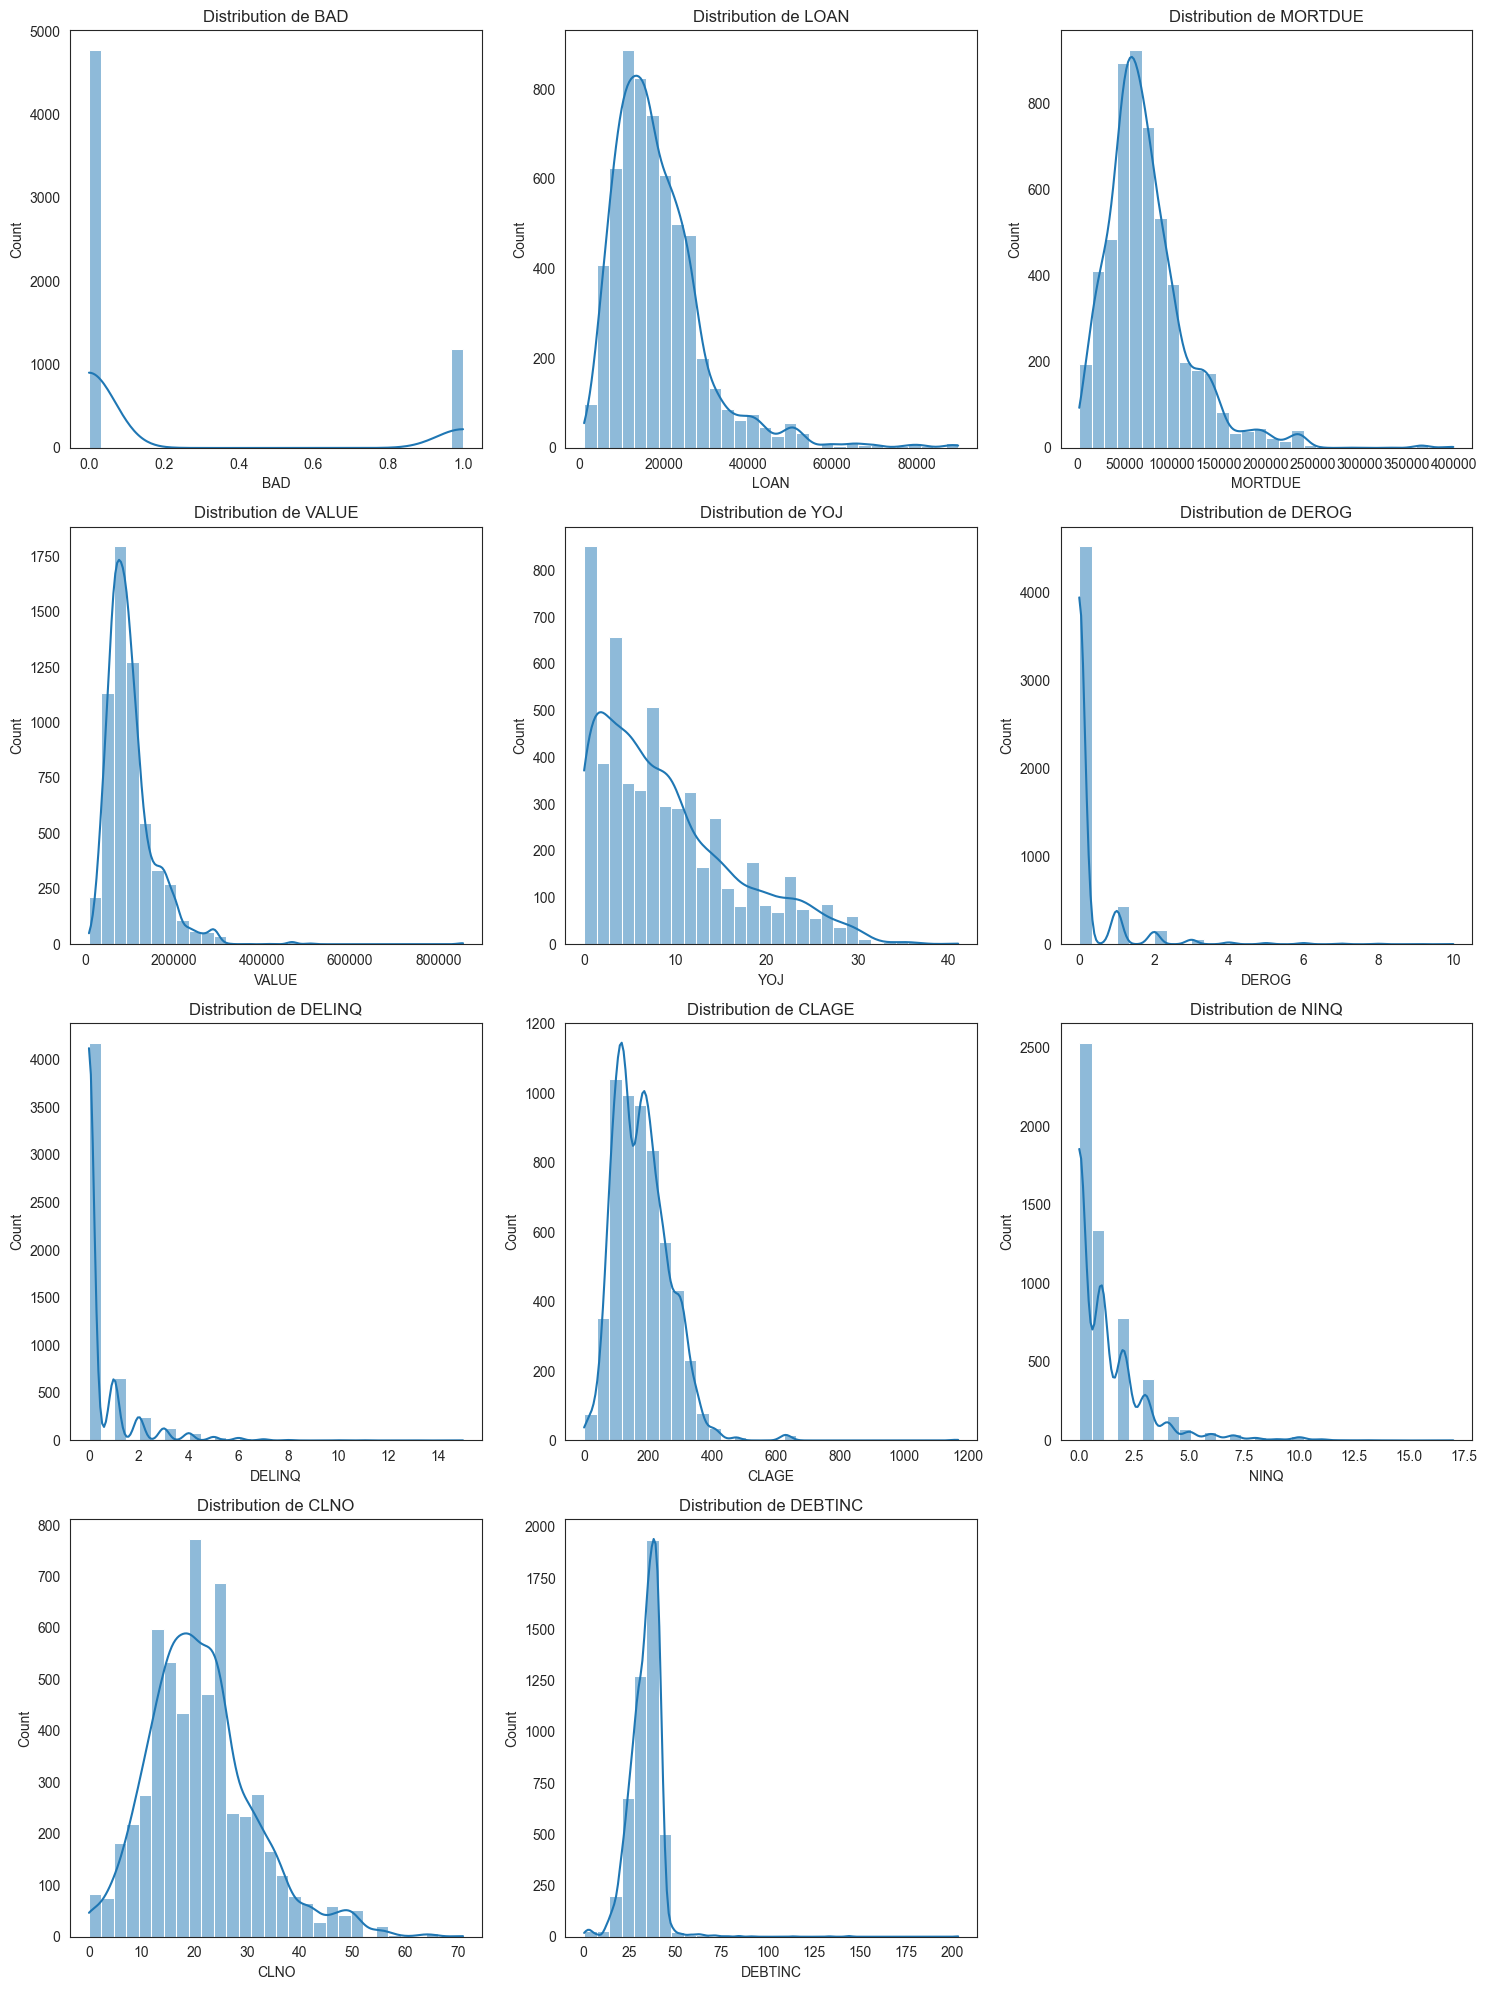

In [36]:
import math

num_cols = df.select_dtypes(include=["number"]).columns

# Déterminer dynamiquement le nombre de lignes et colonnes nécessaires
n_cols = 3  # Nombre de colonnes fixes
n_rows = math.ceil(len(num_cols) / n_cols)  # Calculer le nombre de lignes

plt.figure(figsize=(15, 5 * n_rows))  # Ajuster la taille de la figure

for i, col in enumerate(num_cols, 1):  # Commencer à 1 pour éviter erreur
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f"Distribution de {col}")

plt.tight_layout()
plt.show()

         Valeurs Manquantes  Pourcentage (%)
DEBTINC                1267        21.258389
DEROG                   708        11.879195
DELINQ                  580         9.731544
MORTDUE                 518         8.691275
YOJ                     515         8.640940
NINQ                    510         8.557047
CLAGE                   308         5.167785
JOB                     279         4.681208
REASON                  252         4.228188
CLNO                    222         3.724832
VALUE                   112         1.879195


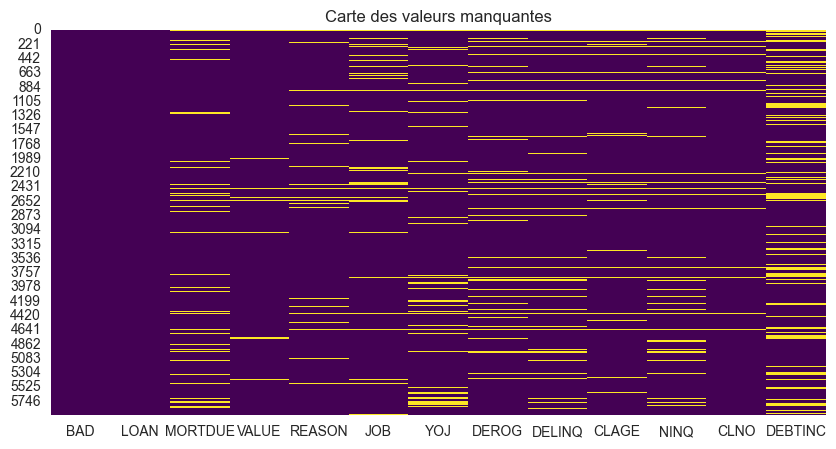

In [37]:
# Calcul du pourcentage de valeurs manquantes
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

# Affichage des colonnes avec valeurs manquantes
missing_df = pd.DataFrame({"Valeurs Manquantes": missing_values, "Pourcentage (%)": missing_percent})
print(missing_df[missing_df["Valeurs Manquantes"] > 0].sort_values(by="Pourcentage (%)", ascending=False))

# Visualisation des valeurs manquantes
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Carte des valeurs manquantes")
plt.show()


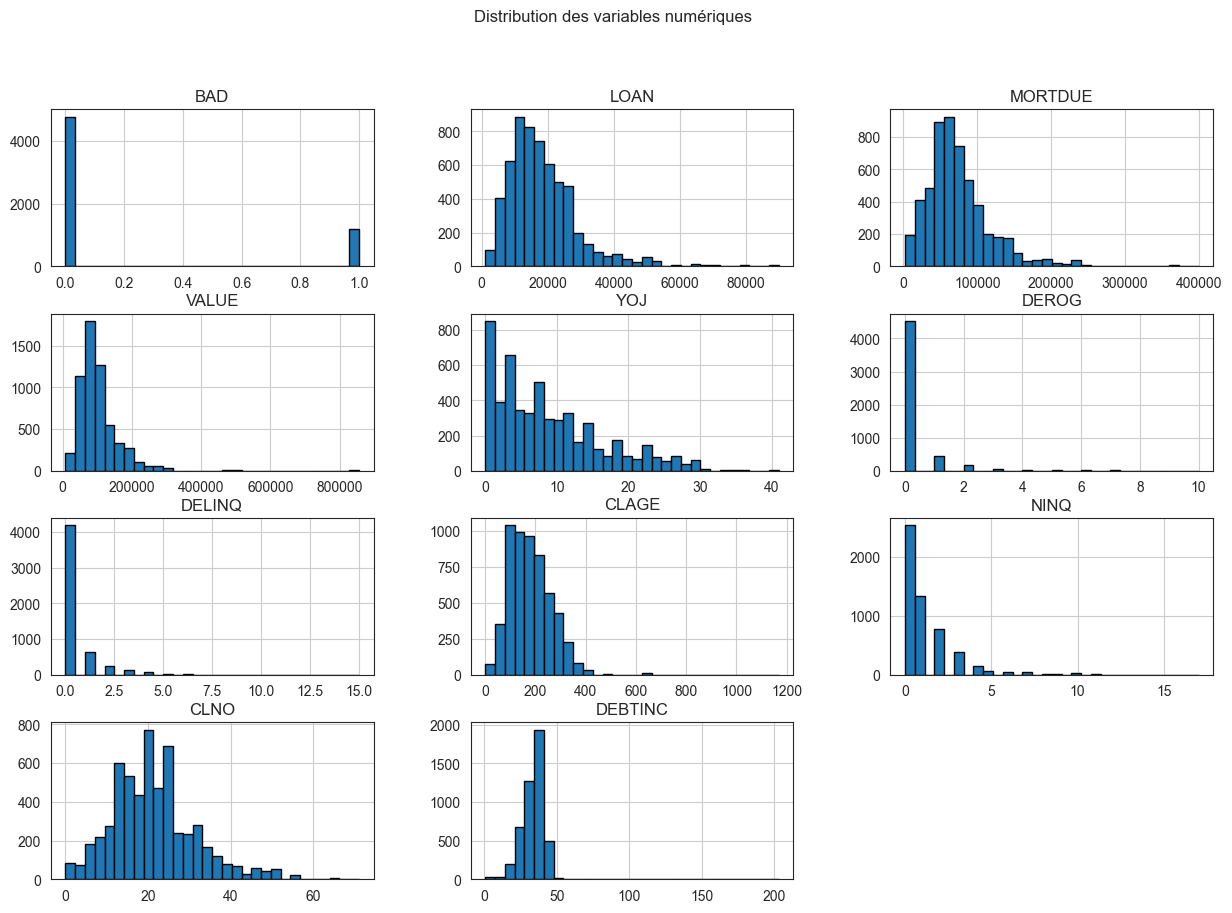

In [38]:
num_cols = df.select_dtypes(include=["number"]).columns

# Histogrammes
df[num_cols].hist(figsize=(15, 10), bins=30, edgecolor="black")
plt.suptitle("Distribution des variables numériques")
plt.show()


In [39]:
# Coefficients d'asymétrie (skewness)
skewness = df[num_cols].apply(lambda x: skew(x.dropna()))
print(skewness.sort_values(ascending=False))


DEROG      5.319350
DELINQ     4.022028
VALUE      3.052561
DEBTINC    2.851442
NINQ       2.621262
LOAN       2.023271
MORTDUE    1.813981
BAD        1.503938
CLAGE      1.343055
YOJ        0.988188
CLNO       0.774849
dtype: float64


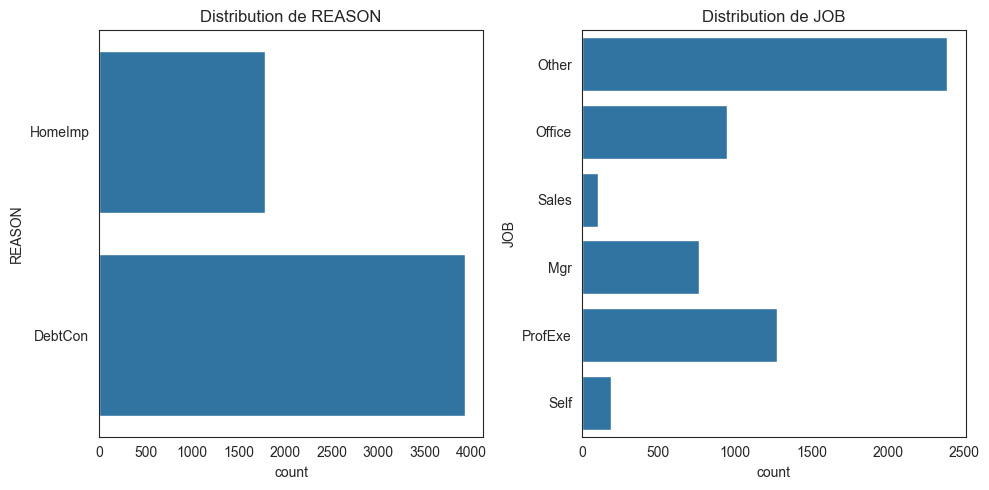

In [40]:
# Sélection des colonnes catégoriques
cat_cols = df.select_dtypes(include=["object"]).columns

plt.figure(figsize=(10, 5))
for i, col in enumerate(cat_cols):
    plt.subplot(1, len(cat_cols), i+1)
    sns.countplot(y=df[col])
    plt.title(f"Distribution de {col}")
plt.tight_layout()
plt.show()


## <span style="color:#0a8791; font-size:24px;"><b><u> Interprétation des statistiques des variables</u></b></span>

#### 1. Présentation Générale du Dataset

- **Nombre de lignes** : 5 960  
- **Nombre de colonnes** : 13  
- **Types de variables** :  
  - Numériques (*float64, int64*) : 11 colonnes  
  - Catégoriques (*object*) : 2 colonnes (**REASON, JOB**)
- Le dataset porte sur des prêts hypothécaires avec un indicateur de risque (**BAD**) et divers paramètres financiers et personnels des emprunteurs.

#### 2. Analyse des Variables

##### 2.1 Variable Cible : **BAD**

- **Type** : Variable binaire (0 = Bon emprunteur, 1 = Mauvais emprunteur)  
- **Distribution** :  
  - 80% des clients sont fiables (**BAD = 0**)
  - 20% des clients ont eu des défauts de paiement (**BAD = 1**)
  - ➝ **Le dataset est déséquilibré**, ce qui peut affecter les performances des modèles de classification.

##### 2.2 Analyse des Variables Explicatives

##### 2.2.1 Variables Financières

- **LOAN** (*Montant du prêt demandé*)
  - Moyenne : **18 610**
  - Min : **1 100** | Max : **89 900**
  - ➝ Distribution asymétrique, présence de valeurs extrêmes.

- **MORTDUE** (*Montant de l'hypothèque actuelle*)
  - Moyenne : **73 760**
  - **8,69%** de valeurs manquantes.
  - Min : **2 063** | Max : **399 550**
  - ➝ Une dette élevée peut être un facteur de risque pour le non-remboursement.

- **VALUE** (*Valeur estimée du bien*)
  - Moyenne : **101 776**
  - Min : **8 000** | Max : **855 909**
  - ➝ Une faible valeur du bien peut indiquer un prêt risqué.

- **DEBTINC** (*Ratio d'endettement*)
  - Moyenne : **33,78%**
  - Max : **203%** (*valeurs extrêmes → peut nécessiter un traitement*)
  - **21,25%** de valeurs manquantes.
  - ➝ Un ratio élevé indique un risque accru d'insolvabilité.

##### 2.2.2 Historique de Crédit

- **DEROG** (*Nombre de comptes avec des incidents graves*)
  - Moyenne : **0,25** (la plupart des clients n’ont pas d'incidents graves)
  - Max : **10**
  - **11,88%** de valeurs manquantes.
  - ➝ La présence de valeurs élevées est un indicateur de risque.

- **DELINQ** (*Nombre de crédits en retard*)
  - Moyenne : **0,45** (majorité sans retard)
  - Max : **15**
  - **9,73%** de valeurs manquantes.
  - ➝ Un historique de retard de paiement est un signal de risque.

- **CLAGE** (*Ancienneté du crédit en mois*)
  - Moyenne : **179,8 mois** (≈ **15 ans**)
  - Min : **0** | Max : **1 168 mois** (≈ **97 ans**)
  - **5,16%** de valeurs manquantes.
  - ➝ Une ancienneté élevée indique un historique de crédit plus stable.

- **CLNO** (*Nombre total de crédits ouverts*)
  - Moyenne : **21,3**
  - Min : **0** | Max : **71**
  - **3,72%** de valeurs manquantes.
  - ➝ Un grand nombre de crédits ouverts peut indiquer une charge financière élevée.

- **NINQ** (*Nombre de nouvelles demandes de crédit*)
  - Moyenne : **1,18**
  - Min : **0** | Max : **17**
  - **8,55%** de valeurs manquantes.
  - ➝ Un grand nombre de nouvelles demandes peut être un signal de surendettement.

##### 2.2.3 Facteurs Socio-Professionnels

- **YOJ** (*Années d’ancienneté dans l’emploi*)
  - Moyenne : **8,92 ans**
  - Min : **0** | Max : **41 ans**
  - **8,64%** de valeurs manquantes.
  - ➝ Une stabilité dans l'emploi est un facteur positif pour l'octroi d'un prêt.

- **REASON** (*Motif du prêt*)
  - Deux catégories : **DebtCon** (*Consolidation de dettes*) et **HomeImp** (*Amélioration de l'habitat*).
  - ➝ Les prêts pour **consolidation de dettes** peuvent être un indicateur de difficultés financières.

- **JOB** (*Type d'emploi*)
  - Plusieurs catégories (*ex. Office, Other, etc.*).
  - ➝ Une corrélation entre certains emplois et le risque de défaut est possible.

#### 3. Problèmes et Nettoyage des Données

- **Données manquantes** :
  - **DEBTINC (21,25%)**, **DEROG (11,88%)**, **DELINQ (9,73%)** sont les plus touchées.
  - ➝ Imputation possible avec la **médiane** ou un **modèle prédictif**.

- **Valeurs extrêmes** :
  - **VALUE, MORTDUE, DEBTINC, CLAGE** présentent des valeurs extrêmes → **normalisation** ou **transformation log**.

- **Déséquilibre de la variable cible** :
  - Il faudra utiliser un **rééchantillonnage** (*SMOTE, undersampling*) pour améliorer la prédiction.

#### 4. Conclusion et Axes d'Analyse

##### Variables clés influençant **BAD** (*risque de défaut*) :
- **Endettement** (**DEBTINC** élevé)
- **Incidents passés** (**DEROG, DELINQ**)
- **Ancienneté du crédit** (**CLAGE**)
- **Valeur du bien** (**VALUE**) vs **dette** (**MORTDUE**)
- **Nouveaux crédits** (**NINQ**)

##### Stratégies pour améliorer la classification des mauvais payeurs :
- Imputation des données manquantes.
- Transformation des variables extrêmes.
- Rééquilibrage des classes.
- Sélection des variables les plus pertinentes.

##### Synthèse
**Déséquilibre de la variable cible** et **données manquantes nécessitant un traitement**.  



##### Conclusion importante à tirer :

Il y a un déséquilibre significatif dans les données, avec une majorité de non-défaillants (80.1%) par rapport aux défaillants (19.9%). Ce déséquilibre peut affecter les performances des modèles de classification standard, qui pourraient être biaisés en faveur de la classe majoritaire.

Pour interpreter les performances de nos modeles : Il est recommandé d'utiliser des métriques d'évaluation adaptées au déséquilibre, telles que l'AUC-ROC, le rappel, la précision, ou la courbe Precision-Recall, plutôt que l'accuracy seule.

https://www.aquiladata.fr/insights/comment-gerer-le-desequilibre-des-classes-dans-un-jeu-de-donnees/